In [3]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### update_df(df)
Simple function which updates the loaded dataframe with three additional columns for further analysis these clumns are **'Q0/HaloMass'** (total halo luminosity of halo mass), **'R_v^3/HaloMass'** (virial radius to the third power divided by the halo mass) and **'StarMass'** (just the mass of the stars in the halo)

**Parameters**:
- **df**: Dataframe that needs to be updated

**Returns**:

In [4]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']
    return

### place_fesc(df)
Helper function that calculates the fraction of halos with an escape fraction below the threshold and sets these values to a small values above this threshold

**Parameters**:
- **fesc_arr**: Array of escape fractions
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)

**Returns**:
- **frac_small**: Fraction of halos with an escape fraction below **threshold**
- **fesc_arr**: Same as the input array with all values below **threshold** replaced by $f_\mathrm{esc} = 1.5 \cdot \mathrm{threshold}+\mathcal{U}(-0.5\cdot \mathrm{threshold},0.5\cdot \mathrm{threshold})$

In [5]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

### get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3)
Return means, error and variance of the escape fraction of each bin, the fraction of halos with small escape fraction for each bin as well as the centers of the bin for a dataframe

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)



**Returns**:
- **x_values**: Masses (star or halo) of the individual halos
- **fesc**: f_esc of all halos
- **centers**: Centers of the logarithmically spaced bins
- **means**: Array of the average f_esc values
- **quantile16**: Values of the 16% quantile
- **quantile84**: Values of the 84% quantile
- **error**: Uncertainties in the average f_esc values
- **variance**: Variance in f_esc in a given bin
- **frac_small_arr**: Fraction of halos with f_esc below **threshold** in each bin 

In [37]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, y_axis='f_esc', lum_weighted=False):
    
    x_values = df.loc[:,halo_prop]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = []
    quantile16 = []
    quantile84 = []
    error = []
    centers = []
    variance = []
    frac_small_arr = []
    
    for i in range(len(edges)-1):
        sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])][y_axis]
        sub_Q0 = df[(edges[i]*(1-1e-10)<df[halo_prop]) & (df[halo_prop]<edges[i+1])]['Q0']
        if mode == 'median':
            means.append(sub_fesc.median())
        elif mode == 'mean':
            if lum_weighted:
                means.append(np.sum(sub_fesc*sub_Q0)/np.sum(sub_Q0))
            else:
                means.append(sub_fesc.mean())
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        quantile16.append(sub_fesc.quantile(0.16))
        quantile84.append(sub_fesc.quantile(0.84))
        error.append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
        variance.append(sub_fesc.var())
        frac_small_arr.append((sub_fesc < threshold).sum()/len(sub_fesc))
        
    means = np.array(means)
    quantile16 = np.array(quantile16)
    quantile84= np.array(quantile84)
    error = np.array(error) 
    centers = np.array(centers)
    variance = np.array(variance)
    frac_small_arr = np.array(frac_small_arr)
    return centers, means, quantile16, quantile84, error, variance, frac_small_arr

### plot_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, include_frac=False, save = False)
Plots scatter and average of the escape fraction for a dataframe as well as the variance in each bin and, if needed the fraction of halos in each bin with an escape fraction below threshold

**Parameters**:
- **df**: Array of escape fractions
- **halo_prop**: Halo property along which to subdivide the dataframe can be either 'StarMass' or 'HaloMass' (default: 'StarMass')
- **bins**: Number of bins (default: 30)
- **mode**: How to calculate the average escape fraction 'mean' or 'median' (default: 'median')
- **threshold**: Threshold below which the escape fraction is considered small (default: 1e-3)
- **include_frac**: If 'True' adds an additional plot with the fraction of halos in each bin below a certain threshold (default: False)
- **save**: If 'True' saves the plot to the 'plots' directory as '**halo_prop**_fesc.pdf' (default: False)




**Returns**:

In [49]:
def plot_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshold=1e-3, include_frac=False, lum_weighted=False,
                 save=False, lin=False, galaxy=False, include_galaxy=False, z_fracs=True, include_var=True, colors=None):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 6
    quantile_alpha = 0.3
    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 20
    fig_height = 25
    axes_width = 3
    tick_labelsize = 35
    y_lim_low=0.0
    y_lim_high=0.56
    
    
    var_lim_low = 1e-3
    var_lim_high = 0.3
    if colors == None:
        colors = ['orange', 'lime', 'royalblue']

    if halo_prop == 'HaloMass':
        x_label = '$M_{\mathrm{vir}} [\log(M_{\u2609})]$'
        plot_col = 1
        prop = halo_prop
    elif halo_prop == 'StarMass':    
        x_label = '$M_{\star} [\log(M_{\u2609})]$'
        plot_col = 1
        prop = halo_prop
    elif halo_prop == 'both':
        x_label = '$M_{\star} [\log(M_{\u2609})]$'
        x_label_2 = '$M_{\mathrm{vir}} [\log(M_{\u2609})$]'
        plot_col = 2
        prop = 'StarMass'
        fig_width = 2*fig_width
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    if galaxy:
        y_axis = 'f_esc_0_2' 
        y_label = '$f_\mathrm{esc, gal}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc, gal})$'
        low_esc_label = '$P(f_\mathrm{esc, gal}<10^{-3})$'
    else:
        y_axis = 'f_esc' 
        median_label = r'$\langle f_\mathrm{esc} \rangle $'
        median_gal_label = r'$\langle f_\mathrm{esc, gal} \rangle $'
        y_label = '$f_\mathrm{esc}$'
        var_label = '$\mathrm{var}(f_\mathrm{esc})$'
        low_esc_label = '$P(f_\mathrm{esc}<10^{-2})$'
    
    if halo_prop != 'both':
        centers, means, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df, halo_prop=prop, 
                                                                                              bins=bins, mode=mode, 
                                                                                              y_axis=y_axis,
                                                                                              threshold=threshold)
        if z_fracs:
            _, _, _, _, _, _, frac_small_arr_6 = get_scatter(df[df.z==6], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold)
            _, _, _, _, _, _, frac_small_arr_8 = get_scatter(df[df.z==8], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold)
            _, _, _, _, _, _, frac_small_arr_10 = get_scatter(df[df.z==10], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold)
        if include_galaxy:
            _, means_gal, *_ = get_scatter(df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis='f_esc_0_2')
    else:
        centers, means, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df, halo_prop='StarMass', 
                                                                                              bins=bins, mode=mode, 
                                                                                              y_axis=y_axis, 
                                                                                              threshold=threshold,
                                                                                             lum_weighted=lum_weighted)
        if z_fracs:
            centers_6, means_6, _, _, _, _, frac_small_arr_6 = get_scatter(df[df.z==6], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                             lum_weighted=lum_weighted)
            centers_8, means_8, _, _, _, _, frac_small_arr_8 = get_scatter(df[df.z==8], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                             lum_weighted=lum_weighted)
            centers_10, means_10, _, _, _, _, frac_small_arr_10 = get_scatter(df[df.z==10], halo_prop=prop, bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                              lum_weighted=lum_weighted)
            
        centers_2, means_2, quantile16_2, quantile84_2, error_2, variance_2, frac_small_arr_2 = get_scatter(df, 
                                                                                            halo_prop='HaloMass', 
                                                                                            bins=bins, mode=mode, 
                                                                                            y_axis=y_axis, 
                                                                                            threshold=threshold,
                                                                                            lum_weighted=lum_weighted)
        if z_fracs:
            centers_6_2, means_6_2, _, _, _, _, frac_small_arr_6_2 = get_scatter(df[df.z==6], halo_prop='HaloMass', bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                               lum_weighted=lum_weighted)
            centers_8_2, means_8_2, _, _, _, _, frac_small_arr_8_2 = get_scatter(df[df.z==8], halo_prop='HaloMass', bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                               lum_weighted=lum_weighted)
            centers_10_2, means_10_2, _, _, _, _, frac_small_arr_10_2 = get_scatter(df[df.z==10], halo_prop='HaloMass', bins=bins, 
                                                             mode=mode, y_axis=y_axis, threshold=threshold,
                                                               lum_weighted=lum_weighted)
        if include_galaxy:
            _, means_gal, *_ = get_scatter(df, halo_prop='StarMass', bins=bins, mode=mode, y_axis='f_esc_0_2')
            _, means_gal_2, *_ = get_scatter(df, halo_prop='HaloMass', bins=bins, mode=mode, y_axis='f_esc_0_2')


    f_esc = np.array(df[y_axis])
    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)
    plt.subplots_adjust(wspace=0.001)

    if include_var and include_frac:
        ax1 = plt.subplot2grid((4, plot_col), (0,0), rowspan=2)
    elif include_var or include_frac:
        ax1 = plt.subplot2grid((3, plot_col), (0,0), rowspan=2)
    else:
        ax1 = plt.subplot2grid((2, plot_col), (0,0), rowspan=2)
    
    if lum_weighted:
        if z_fracs:
            x_bins_6 = np.log10(centers_6*mult)
            ax1.plot(x_bins_6, means_6, linewidth=linewidth, label='z=6')
            
            x_bins_8 = np.log10(centers_8*mult)
            ax1.plot(x_bins_8, means_8, linewidth=linewidth, label='z=8')
            
            x_bins_10 = np.log10(centers_10*mult)
            ax1.plot(x_bins_10, means_10, linewidth=linewidth, label='z=10')
        else:
            x_bins = np.log10(centers*mult)
            ax1.plot(x_bins, means, linewidth=linewidth,  color='black', label=median_label)
    else:
        for i,z in enumerate(redshifts):
            sub_df = df[df.z==z]
            x_ax_val = np.array(sub_df[prop])
            _, y_ax_val =  place_fesc(np.array(sub_df[y_axis]), threshold)
            ax1.scatter(np.log10(x_ax_val*mult), y_ax_val, label=f'z={z}', zorder=-15, color=colors[i])
        x_bins = np.log10(centers*mult)
        ax1.plot(x_bins, means, linewidth=linewidth,  color='black', label=median_label)
        if include_galaxy:
            ax1.plot(x_bins, means_gal, linewidth=linewidth,  color='black', linestyle='--', label=median_gal_label)
        ax1.fill_between(x_bins, quantile16, quantile84, color='black', alpha=quantile_alpha)
    #ax1.errorbar(np.log10(centers*mult), means, yerr=error, linewidth=4, elinewidth=2, capsize=10, color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(threshold, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)
    ax1.set_rasterization_zorder(-15)
    
    if include_var:
        if include_frac:
            ax2 = plt.subplot2grid((4,plot_col), (2,0), sharex=ax1)
        else:
            ax2 = plt.subplot2grid((3,plot_col), (2,0), sharex=ax1)
        ax2.plot(np.log10(centers*mult), variance, linewidth=linewidth, color='black')
        ax2.set_ylabel(var_label, size=size_label)
        ax2.set_xlabel(x_label, size=size_label)
        ax2.set_yscale('log')
        ax2.set_ylim(var_lim_low,var_lim_high)
        ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    
    if include_frac:
        if include_var:
            ax3 = plt.subplot2grid((4,plot_col), (3,0), sharex=ax2)
        else:
            ax3 = plt.subplot2grid((3,plot_col), (2,0), sharex=ax1)
        if z_fracs:
            ax3.plot(np.log10(centers*mult), frac_small_arr_6, linewidth=linewidth, label=f'z=6')
            ax3.plot(np.log10(centers*mult), frac_small_arr_8, linewidth=linewidth, label=f'z=8')
            ax3.plot(np.log10(centers*mult), frac_small_arr_10, linewidth=linewidth, label=f'z=10')
        else:
            ax3.plot(np.log10(centers*mult), frac_small_arr, linewidth=linewidth, color='black')
        ax3.legend(fontsize=legend_fontsize, loc=legend_loc)
        ax3.set_ylabel(low_esc_label, size=size_label)
        ax3.set_xlabel(x_label, size=size_label)
        ax3.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax3.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
        ax3.set_ylim(y_lim_low, y_lim_high)
        
    if halo_prop == 'both':
        if include_var and include_frac:
            ax1_2 = plt.subplot2grid((4, plot_col), (0,1), rowspan=2, sharey=ax1)
        elif include_var or include_frac:
            ax1_2 = plt.subplot2grid((3, plot_col), (0,1), rowspan=2, sharey=ax1)
        else:
            ax1_2 = plt.subplot2grid((2, plot_col), (0,1), rowspan=2, sharey=ax1)
            
        if lum_weighted:
            if z_fracs:
                x_bins_6_2 = np.log10(centers_6_2*mult)
                ax1_2.plot(x_bins_6_2, means_6_2, linewidth=linewidth, label='z=6')

                x_bins_8_2 = np.log10(centers_8_2*mult)
                ax1_2.plot(x_bins_8_2, means_8_2, linewidth=linewidth, label='z=8')

                x_bins_10_2 = np.log10(centers_10_2*mult)
                ax1_2.plot(x_bins_10_2, means_10_2, linewidth=linewidth, label='z=10')
            
            else:
                x_bins_2 = np.log10(centers_2*mult)
                ax1_2.plot(x_bins_2, means_2, linewidth=linewidth,  color='black', label=median_label)
        else:
            for i,z in enumerate(redshifts):
                sub_df = df[df.z==z]
                x_ax_val = np.array(sub_df['HaloMass'])
                _, y_ax_val =  place_fesc(np.array(sub_df[y_axis]), threshold)
                ax1_2.scatter(np.log10(x_ax_val*mult), y_ax_val, label=f'z={z}', zorder=-15, color=colors[i])
            x_bins_2 = np.log10(centers_2*mult)
            ax1_2.plot(x_bins_2, means_2, linewidth=linewidth,  color='black', label=median_label)
            if include_galaxy:
                ax1_2.plot(x_bins_2, means_gal_2, linewidth=linewidth,  color='black', linestyle='--', label=median_gal_label)
            ax1_2.fill_between(x_bins_2, quantile16_2, quantile84_2, color='black', alpha=quantile_alpha)
            #ax1.errorbar(np.log10(centers*mult), means, yerr=error, linewidth=4, elinewidth=2, capsize=10, color='red', label=r'$\langle f_\mathrm{esc} \rangle$')
            if lin:
                ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
            else:
                ax1.set_yscale('log')
                ax1.set_ylim(threshold, upper_y_threshold)
        #ax1_2.set_ylabel(y_label, size=size_label)
        ax1_2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax1_2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
        ax1_2.axes.yaxis.set_visible(False)
        ax1_2.legend(fontsize=legend_fontsize, loc=legend_loc)
        ax1_2.set_rasterization_zorder(-15)

        if include_var:
            if include_frac:
                ax2_2 = plt.subplot2grid((4,plot_col), (2,1), sharex=ax1_2, sharey=ax2)
            else:
                ax2_2 = plt.subplot2grid((3,plot_col), (2,1), sharex=ax1_2, sharey=ax2)
            ax2_2.plot(np.log10(centers_2*mult), variance_2, linewidth=linewidth, color='black')
            #ax2_2.set_ylabel(var_label, size=size_label)
            ax2_2.set_xlabel(x_label_2, size=size_label)
            ax2_2.set_yscale('log')
            ax2_2.set_ylim(var_lim_low,var_lim_high)
            ax2_2.axes.yaxis.set_visible(False)
            ax2_2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
            ax2_2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

        if include_frac:
            if include_var:
                ax3_2 = plt.subplot2grid((4,plot_col), (3,1), sharex=ax2_2, sharey=ax3)
            else:
                ax3_2 = plt.subplot2grid((3,plot_col), (2,1), sharex=ax1_2, sharey=ax3)
            if z_fracs:
                ax3_2.plot(np.log10(centers_2*mult), frac_small_arr_6_2, linewidth=linewidth, label=f'z=6')
                ax3_2.plot(np.log10(centers_2*mult), frac_small_arr_8_2, linewidth=linewidth, label=f'z=8')
                ax3_2.plot(np.log10(centers_2*mult), frac_small_arr_10_2, linewidth=linewidth, label=f'z=10')
            else:
                ax3_2.plot(np.log10(centers_2*mult), frac_small_arr_2, linewidth=linewidth, color='black')
            ax3_2.axes.yaxis.set_visible(False)
            ax3_2.legend(fontsize=legend_fontsize, loc=legend_loc)
            ax3_2.set_ylim(y_lim_low, y_lim_high)
            #ax3_2.set_ylabel(low_esc_label, size=size_label)
            ax3_2.set_xlabel(x_label_2, size=size_label)
            ax3_2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
            ax3_2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')

    #xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    #plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            if galaxy:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_galaxy.pdf'
            else:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [27]:
def plot_dust_comparison(comparison_df, runs, halo_prop='StarMass', bins=30, mode='average', scatter=False,
                         save=False, lin=False, residual=False, with_z=False, colors=['red', 'blue'], labels = ['no dust', 'dust']):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 4
    markersize = 260
    markersize_scat = 100
    if residual:
        upper_y_threshold = 1e-2
        lower_y_threshold_lin = 0.
        lower_y_threshold_log = 1e-6
    else:
        upper_y_threshold = 1.
        lower_y_threshold_lin = 0.
        lower_y_threshold_log = 1e-3
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 35
    linestyles = {'dust': '--', 'no_dust':'-'}
    markers = {'dust':'x', 'no_dust':'+'}
    
    results = {}
    for run in runs:
        results[run] = {}
        if with_z:
            results[run]['x'] = {}
            results[run]['y'] = {}

    if halo_prop == 'HaloMass':
        x_label = '$M_\mathrm{vir} [\log(M_{\u2609})]$'
    elif halo_prop == 'StarMass':    
        x_label = '$M_\star [\log(M_{\u2609})]$'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    if residual:
        y_label = '$f_\mathrm{esc, no\_dust}-f_\mathrm{esc, dust}$'
    else: 
        y_label = '$f_\mathrm{esc}$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    if with_z:
        for z in redshifts: 
            for run in runs:
                centers, means, *_ = get_scatter(comparison_df[comparison_df.z==z], halo_prop=halo_prop, bins=bins, 
                                                           mode=mode, y_axis=f'f_esc_{run}')

                results[run]['x'][z] = centers
                results[run]['y'][z] = means
    else:
        for run in runs:
            centers, means, *_ = get_scatter(comparison_df, halo_prop=halo_prop, bins=bins, mode=mode, y_axis=f'f_esc_{run}')
            results[run]['x'] = centers
            results[run]['y'] = means

    f = plt.figure()
    ax1 = plt.subplot()
    
    if with_z:
        if residual:
            for i, redshift in enumerate(redshifts):
                x_values_dust = np.log10(results['dust']['x'][redshift]*mult)
                y_values_dust = results['dust']['y'][redshift]
                y_values_no_dust = results['no_dust']['y'][redshift]
                ax1.scatter(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color=colors[i], marker='+', label=fr'$z={redshift}$')

        else:
            for i, redshift in enumerate(redshifts):
                for j,run in enumerate(runs):
                    x_values = np.log10(results[run]['x'][redshift]*mult)
                    y_values = results[run]['y'][redshift]
                    ax1.plot(x_values, y_values, linewidth=linewidth, linestyle=linestyles[run],  color=colors[i], label=fr'{labels[j]}: $z={redshift}$')
    else:
        if residual:
            x_values_dust = np.log10(results['dust']['x']*mult)
            y_values_dust = results['dust']['y']
            y_values_no_dust = results['no_dust']['y']
            ax1.plot(x_values_dust, y_values_no_dust-y_values_dust, linewidth=linewidth,  color='red', marker='+', s=markersize)

        else:
            for i,run in enumerate(runs):
                x_values = np.log10(results[run]['x']*mult)            
                y_values = results[run]['y']
                ax1.plot(x_values, y_values, label=labels[i], linewidth=linewidth, color=colors[i])
        if scatter:
            for i,run in enumerate(runs):
                x_values = np.log10(comparison_df[halo_prop]*mult)            
                y_values = comparison_df[f'f_esc_{run}']
                ax1.scatter(x_values, y_values, s=markersize_scat, marker=markers[run], color=colors[i])
            
    
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if residual:
            if lin:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_lin_residual'
            else:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_residual'
        else:
            if lin:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc_lin'
            else:
                path = f'/u/ivkos/analysis/plots/dust_comparison_{halo_prop}_fesc'
        if scatter:
            path = path+'_scatter.pdf'
        else:
            path = path+'.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [9]:
def plot_lit_comparison(df, compare_fesc, include_subgrid=True, halo_prop='HaloMass', bins=30, mode='mean', save=False, lin=False):
        
    redshifts = [6,8,10]
    mult = 1e10/h
    
    linewidth = 8
    upper_y_threshold = 1.
    lower_y_threshold_lin = 0.
    lower_y_threshold_log = 1e-2
    size_label = 62
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 25
    legend_loc = 'lower right'
    fig_width = 25
    fig_height = 20
    axes_width = 3
    tick_labelsize = 45
    if halo_prop == 'HaloMass':
        x_range_lower = 8.55
        x_range_upper = 11.5
    else:
        x_range_lower = 6.0
        x_range_upper = 9.45
    markersize = 250
    
    if include_subgrid:
        fesc_loc_fid2 = 1.0
        fesc_loc_lewis = 0.42
    else:
        fesc_loc_fid2 = 1.0
        fesc_loc_lewis = 1.0
        
    
    compare_fesc['TNG'] = {}
    compare_fesc['TNG']['x'] = {}
    compare_fesc['TNG']['y'] = {}

    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
        prop = halo_prop
        plot_col = 1
        compare_fesc['TNG']['x'][prop] = {}
        compare_fesc['TNG']['y'][prop] = {}
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
        prop = halo_prop
        plot_col = 1
        compare_fesc['TNG']['x'][prop] = {}
        compare_fesc['TNG']['y'][prop] = {}
    elif halo_prop == 'both':
        x_label = '$M_{\star} [\log(M_{\u2609})]$'
        x_label_2 = '$M_{\mathrm{vir}} [\log(M_{\u2609})]$'
        prop = 'StarMass'
        plot_col = 2
        fig_width = 2*fig_width
        compare_fesc['TNG']['x'][prop] = {}
        compare_fesc['TNG']['y'][prop] = {}
        compare_fesc['TNG']['x']['HaloMass'] = {}
        compare_fesc['TNG']['y']['HaloMass'] = {}
        x_range_lower_2 = 8.4
        x_range_upper_2 = 11.5
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    y_axis = 'f_esc' 
    y_label = r'$\langle f_\mathrm{esc} \rangle $'
    #y_label = '$< f_\mathrm{esc} >$'
    var_label = '$\mathrm{var}(f_\mathrm{esc})$'
    low_esc_label = '$P(f_\mathrm{esc}<10^{-3})$'
    
    for z in redshifts: 
        centers, means, *_ = get_scatter(df[df.z==z], halo_prop=prop, bins=bins, mode=mode, y_axis=y_axis)
        compare_fesc['TNG']['x'][prop][z] = centers
        compare_fesc['TNG']['y'][prop][z] = means
        if halo_prop == 'both':
            centers_2, means_2, *_ = get_scatter(df[df.z==z], halo_prop='HaloMass', bins=bins, mode=mode, y_axis=y_axis)
            compare_fesc['TNG']['x']['HaloMass'][z] = centers_2
            compare_fesc['TNG']['y']['HaloMass'][z] = means_2
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)
    plt.subplots_adjust(wspace=0.001)
    ax1 = plt.subplot2grid((1, plot_col), (0,0), rowspan=2)
    #ax1 = plt.subplot()
    x_values = np.log10(compare_fesc['TNG']['x'][prop][6]*mult)
    y_values = compare_fesc['TNG']['y'][prop][6]
    ax1.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=6$')
    
    x_values = np.log10(compare_fesc['TNG']['x'][prop][8]*mult)
    y_values = compare_fesc['TNG']['y'][prop][8]
    ax1.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=8$')
    
    x_values = np.log10(compare_fesc['TNG']['x'][prop][10]*mult)
    y_values = compare_fesc['TNG']['y'][prop][10]
    ax1.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=10$')
    
    cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    if halo_prop == 'HaloMass':
        x_values = compare_fesc['Ma2020']['x_900_halo']
        y_values = compare_fesc['Ma2020']['y_900_halo']
        ax1.scatter(x_values, y_values, color='orange', s=markersize, marker='s', label=r'FIRE-II: $m_b \leq 900M_\mathrm{sun}$')

        x_values = compare_fesc['Ma2020']['x_7000_halo']
        y_values = compare_fesc['Ma2020']['y_7000_halo']
        ax1.scatter(x_values, y_values, color='cyan', s=markersize, marker='s', label=r'FIRE-II: $m_b \approx 7000M_\mathrm{sun}$')
        
        x_values = compare_fesc['Paardekooper2015']['x_6_halo']
        y_values = compare_fesc['Paardekooper2015']['y_6_halo']
        ax1.scatter(x_values, y_values, color='green', s=markersize, label=r'FIBY: $z=6$')

        x_values = compare_fesc['Paardekooper2015']['x_8_9_halo']
        y_values = compare_fesc['Paardekooper2015']['y_8_9_halo']
        ax1.scatter(x_values, y_values, color='purple', s=markersize, label=r'FIBY: $z=8.9$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_6']#*fesc_loc_lewis
        ax1.scatter(x_values, y_values, color=cycle[0], s=markersize, marker='^', label=r'CODA-II: $z=6$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_8']#*fesc_loc_lewis
        ax1.scatter(x_values, y_values, color=cycle[1], s=markersize, marker='^', label=r'CODA-II: $z=8$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_10']#*fesc_loc_lewis
        ax1.scatter(x_values, y_values, color=cycle[2], s=markersize, marker='^', label=r'CODA-II: $z=10.1$')

    elif (halo_prop == 'StarMass') or (halo_prop == 'both'):
        x_values = compare_fesc['Ma2020']['x_900_star']
        y_values = compare_fesc['Ma2020']['y_900_star']
        ax1.scatter(x_values, y_values, color='orange', s=markersize, marker='s', label=r'FIRE-II: $m_b \leq 900M_\mathrm{sun}$')

        x_values = compare_fesc['Ma2020']['x_7000_star']
        y_values = compare_fesc['Ma2020']['y_7000_star']
        ax1.scatter(x_values, y_values, color='cyan', s=markersize, marker='s', label=r'FIRE-II: $m_b \approx 7000M_\mathrm{sun}$')
        
        x_values = compare_fesc['Paardekooper2015']['x_6_star']
        y_values = compare_fesc['Paardekooper2015']['y_6_star']
        ax1.scatter(x_values, y_values, color='green', s=markersize, label=r'FIBY: $z=6$')

        x_values = compare_fesc['Paardekooper2015']['x_8_9_star']
        y_values = compare_fesc['Paardekooper2015']['y_8_9_star']
        ax1.scatter(x_values, y_values, color='purple', s=markersize, label=r'FIBY: $z=8.9$')
    
    if halo_prop == 'both':
        ax2 = plt.subplot2grid((1, plot_col), (0,1))
        
        x_values = np.log10(compare_fesc['TNG']['x']['HaloMass'][6]*mult)
        y_values = compare_fesc['TNG']['y']['HaloMass'][6]
        ax2.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=6$')

        x_values = np.log10(compare_fesc['TNG']['x']['HaloMass'][8]*mult)
        y_values = compare_fesc['TNG']['y']['HaloMass'][8]
        ax2.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=8$')
        
        x_values = np.log10(compare_fesc['TNG']['x']['HaloMass'][10]*mult)
        y_values = compare_fesc['TNG']['y']['HaloMass'][10]
        ax2.plot(x_values, y_values, linewidth=linewidth, label=r'TNG: $z=10$')

        x_values = compare_fesc['Ma2020']['x_900_halo']
        y_values = compare_fesc['Ma2020']['y_900_halo']
        ax2.scatter(x_values, y_values, color='orange', s=markersize, marker='s', label=r'FIRE-II: $m_b \leq 900M_\mathrm{sun}$')

        x_values = compare_fesc['Ma2020']['x_7000_halo']
        y_values = compare_fesc['Ma2020']['y_7000_halo']
        ax2.scatter(x_values, y_values, color='cyan', s=markersize, marker='s', label=r'FIRE-II: $m_b \approx 7000M_\mathrm{sun}$')
        
        x_values = compare_fesc['Paardekooper2015']['x_6_halo']
        y_values = compare_fesc['Paardekooper2015']['y_6_halo']
        ax2.scatter(x_values, y_values, color='green', s=markersize, label=r'FIBY: $z=6$')

        x_values = compare_fesc['Paardekooper2015']['x_8_9_halo']
        y_values = compare_fesc['Paardekooper2015']['y_8_9_halo']
        ax2.scatter(x_values, y_values, color='purple', s=markersize, label=r'FIBY: $z=8.9$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_6']#*fesc_loc_lewis
        ax2.scatter(x_values, y_values, color=cycle[0], s=markersize, marker='^', label=r'CODA-II: $z=6$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_8']#*fesc_loc_lewis
        ax2.scatter(x_values, y_values, color=cycle[1], s=markersize, marker='^', label=r'CODA-II: $z=8$')
        
        x_values = compare_fesc['Lewis2020']['x_all']
        y_values = compare_fesc['Lewis2020']['y_10']#*fesc_loc_lewis
        ax2.scatter(x_values, y_values, color=cycle[2], s=markersize, marker='^', label=r'CODA-II: $z=10.1$')
        
         
        x_values = compare_fesc['ocvirk21']['x_all']
        y_values = compare_fesc['ocvirk21']['y_permissive']
        ax2.scatter(x_values, y_values, color='red', s=markersize, marker='D', label=r'RAMSES-CUDATON: permissive')
                    
        x_values = compare_fesc['ocvirk21']['x_all']
        y_values = compare_fesc['ocvirk21']['y_fiducial']
        ax2.scatter(x_values, y_values, color='green', s=markersize, marker='D', label=r'RAMSES-CUDATON: fiducial')
        
        
        x_values = compare_fesc['kimm14']['x_7']
        y_values = compare_fesc['kimm14']['y_7']
        ax2.scatter(x_values, y_values, color='brown', s=markersize, marker='h', label=r'RAMSES: z=7')
        
        x_values = compare_fesc['kimm14']['x_9']
        y_values = compare_fesc['kimm14']['y_9']
        ax2.scatter(x_values, y_values, color='yellow', s=markersize, marker='h', label=r'RAMSES: z=9')
        
        x_values = compare_fesc['kimm14']['x_11']
        y_values = compare_fesc['kimm14']['y_11']
        ax2.scatter(x_values, y_values, color='violet', s=markersize, marker='h', label=r'RAMSES: z=11')
        
        ax2.axes.yaxis.set_visible(False)
    
    if lin:
        ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
        if halo_prop == 'both':
            ax2.set_ylim(lower_y_threshold_lin, upper_y_threshold)
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(lower_y_threshold_log, upper_y_threshold)
        if halo_prop == 'both':
            ax2.set_yscale('log')
            ax2.set_ylim(lower_y_threshold_log, upper_y_threshold)
    
    ax1.set_xlim(x_range_lower, x_range_upper)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)
    
    if halo_prop == 'both':
        ax2.set_xlim(x_range_lower_2, x_range_upper_2)
        ax2.set_xlabel(x_label_2, size=size_label)
        ax2.set_ylabel(y_label, size=size_label)
        ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
        ax2.legend(fontsize=legend_fontsize, loc=legend_loc)

    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_lit_comp.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [10]:
def build_compare_dic():
    compare_fesc = {}
    compare_fesc['Ma2020'] = {}
    compare_fesc['Paardekooper2015'] = {}
    compare_fesc['Lewis2020'] = {}
    compare_fesc['ocvirk21'] = {}
    compare_fesc['kimm14'] = {}
    
    compare_fesc['Ma2020']['x_900_star'] = [4. , 4.5, 5. , 5.5, 6. , 6.5, 7. , 7.5, 8. , 8.5, 9. ]
    compare_fesc['Ma2020']['x_7000_star'] = [ 6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]
    compare_fesc['Ma2020']['y_900_star'] = [0.06, 0.04,0.08, 0.1,0.14,0.19,0.25,0.24, 0.27,0.25,0.23]
    compare_fesc['Ma2020']['y_7000_star'] = [0.06, 0.1, 0.14, 0.15, 0.12, 0.11, 0.09, 0.07]
    
    compare_fesc['Ma2020']['x_900_halo'] = [ 8. ,  8.3,  8.6,  8.9,  9.2,  9.5,  9.8, 10.1, 10.4, 10.7, 11. ]
    compare_fesc['Ma2020']['x_7000_halo'] = [ 9.8, 10.08571429, 10.37142857, 10.65714286, 10.94285714,11.22857143, 11.51428571, 11.8]
    compare_fesc['Ma2020']['y_900_halo'] = [0.07,0.17,0.18,0.19,0.24,0.23,0.27,0.23,0.29,0.23,0.24]
    compare_fesc['Ma2020']['y_7000_halo'] = [0.16,0.14,0.145,0.14,0.13,0.1,0.8,0.5]
    
    compare_fesc['Paardekooper2015']['x_6_halo'] = np.log10([8e6, 1.2e7, 1.9e7, 3e7, 4.2e7, 5.5e7, 8e7,1.2e8, 1.8e8, 2.7e8, 4e8, 5.9e8, 8.5e8, 1.3e9, 1.9e9,2.8e9,4e9])
    compare_fesc['Paardekooper2015']['y_6_halo'] = [0.2, 0.2, 0.28, 0.34, 0.4, 0.3, 0.22, 0.1, 0.05, 0.006, 0.13, 0.002, 0.003, 0.2, 0.0002, 0.09, 1]

    compare_fesc['Paardekooper2015']['x_6_star'] = np.log10([1.3e3, 2.5e3, 5e3, 9e3, 1.8e4, 3e4, 5.5e4, 1e5, 1.9e5, 3.2e5, 6e5, 1e6, 2e6, 7e6, 1.2e7, 2.2e7, 4.2e7, 8e7, 1.04e8])
    compare_fesc['Paardekooper2015']['y_6_star'] = [0.3, 0.3, 0.22, 0.2, 0.12, 0.13, 0.02, 0.015, 0.005, 0.005, 0.002, 0., 0.002, 0.2, 0.2, 0., 1., 1., 1.]

    compare_fesc['Paardekooper2015']['x_8_9_halo'] = np.log10([2.5e6, 4.1e6, 8e6, 1.2e7, 1.9e7, 3e7, 4.2e7, 5.5e7, 8e7,1.2e8, 1.8e8, 2.7e8, 4e8, 5.9e8, 8.5e8, 1.3e9, 1.9e9, 2.8e9, 4e9])
    compare_fesc['Paardekooper2015']['y_8_9_halo'] = [0.06, 0.2, 0.09, 0.08, 0.06, 0.05, 0.04, 0.03, 0.02, 0.025, 0.018, 0.008, 0.004, 0.001, 0.0004, 0.0005, 0.0003, 0.12, 0.25]

    compare_fesc['Paardekooper2015']['x_8_9_star'] = np.log10([1.3e3, 2.5e3, 5e3, 9e3, 1.8e4, 3e4, 5.5e4, 1e5, 1.9e5, 3.2e5, 6e5, 1e6, 1e6, 2e6, 7e6, 1.2e7, 2.2e7, 4.2e7, 8e7, 1.04e8])
    compare_fesc['Paardekooper2015']['y_8_9_star'] = [0.07, 0.06, 0.04, 0.03, 0.023, 0.02, 0.02, 0.023, 0.007, 0.006, 0.009, 0.0009, 0.0004, 0.0006, 0.0007, 0.0004, 0.05, 0.0004, 0.002, 0.2]
    
    compare_fesc['Lewis2020']['x_all'] = [ 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10., 10.2, 10.4, 10.6, 10.8, 11.]
    compare_fesc['Lewis2020']['y_6'] = 10**np.array([-0.05, -0.1 , -0.1 , -0.15, -0.15, -0.2 , -0.3 , -0.4 , -0.5 , -0.6 , -0.7 , -0.8 , -0.85, -0.9, -1.0, -1.0])
    compare_fesc['Lewis2020']['y_8'] = 10**np.array([-0.1 , -0.2 , -0.4 , -0.47, -0.49, -0.55, -0.58, -0.6 , -0.7 , -0.77, -0.79, -0.9, -0.94, -0.95, -0.9, -1.0 ])
    compare_fesc['Lewis2020']['y_10'] = 10**np.array([-0.24, -0.4, -0.6, -0.63, -0.63, -0.67, -0.67, -0.78, -0.78, -0.8, -0.79, -0.93, -0.94, -1.2, -1.7, -1.0])
    
    compare_fesc['ocvirk21']['x_all'] = [8.5, 9, 9.5, 10, 10.5, 11]
    compare_fesc['ocvirk21']['y_permissive'] = 10**np.array([-0.15, -0.18, -0.3, -0.68, -1.0, -1.05]) 
    compare_fesc['ocvirk21']['y_fiducial'] = 10**np.array([-0.15, -0.4, -1.0, -1.5, -2, -2.2]) 
    
    compare_fesc['kimm14']['x_7'] = [8.8, 9.2, 9.7, 10]
    compare_fesc['kimm14']['y_7'] = [0.2, 0.15, 0.1, 0.1]
    compare_fesc['kimm14']['x_9'] = [8.6, 9.1, 9.4, 9.8]
    compare_fesc['kimm14']['y_9'] = [0.12, 0.14, 0.16, 0.07]
    compare_fesc['kimm14']['x_11'] = [8.7, 9.1, 9.4]
    compare_fesc['kimm14']['y_11'] = [0.11, 0.1, 0.12]

    return compare_fesc

In [11]:
df=pd.read_pickle('dfs/esc_analysis.pickle')
update_df(df)

In [9]:
colors = ['red', 'blue', 'green']

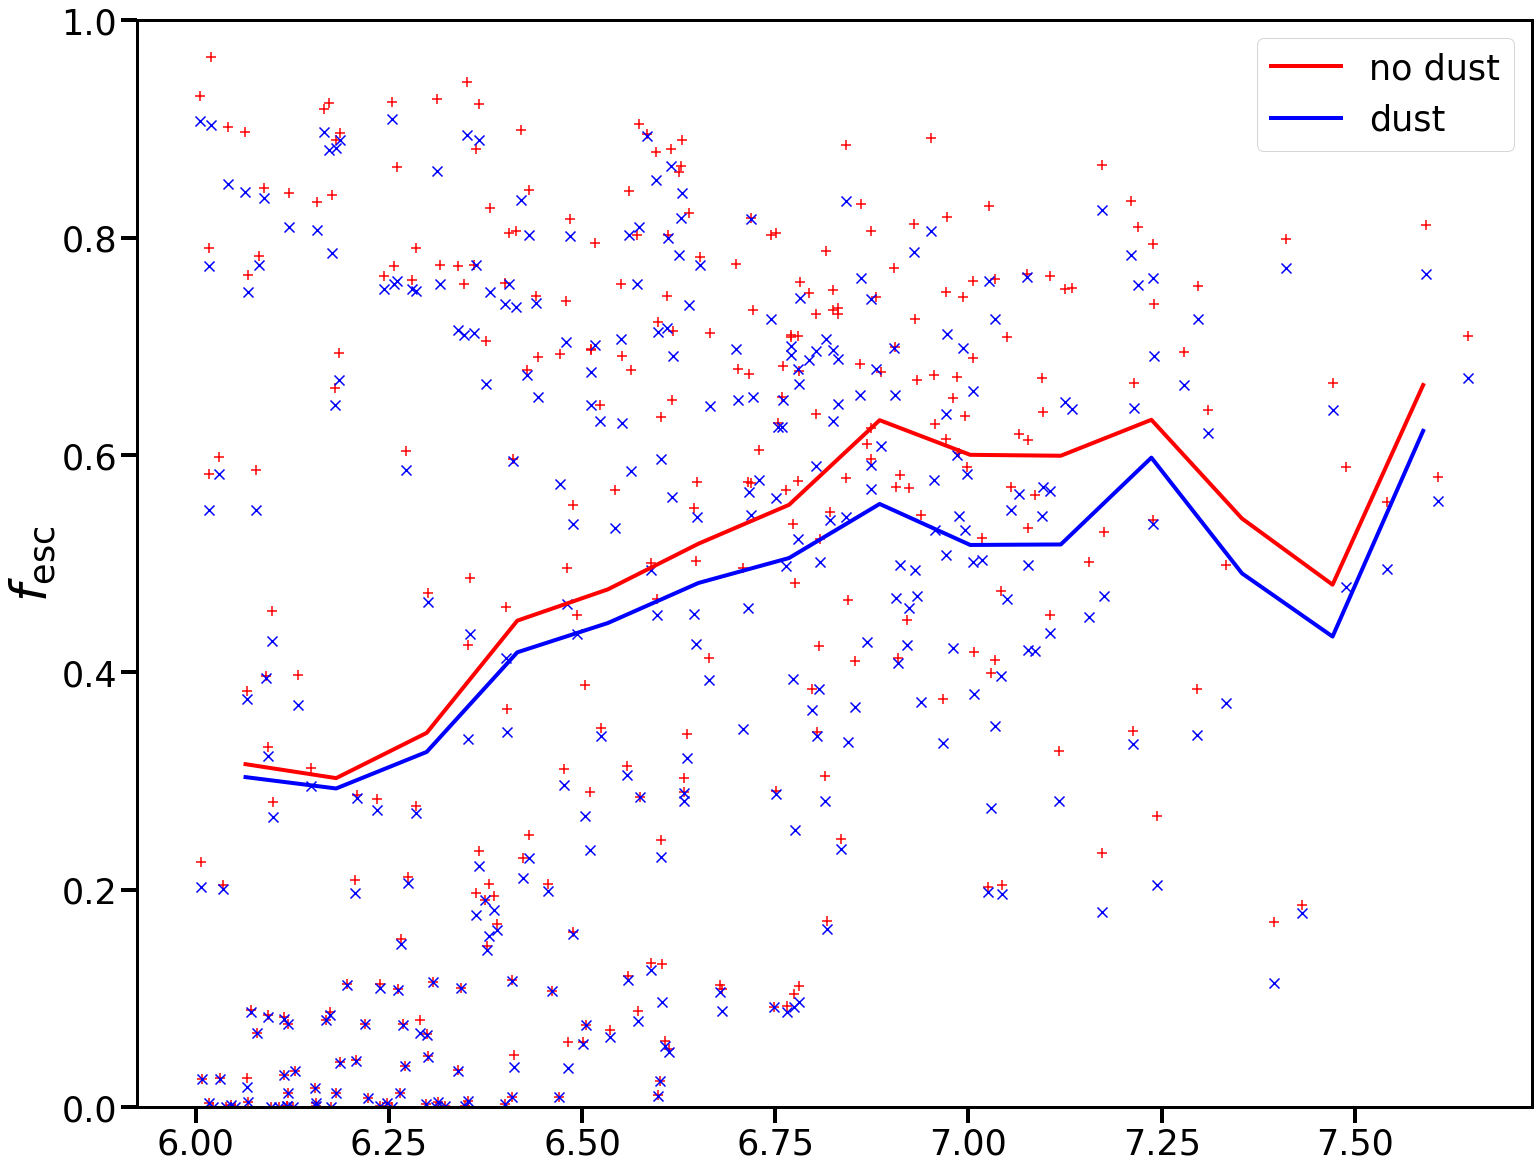

In [192]:
plot_dust_comparison(df_intersection, runs=['no_dust', 'dust'], halo_prop='StarMass', bins=15, mode='mean', scatter=True,
                         save=True, lin=True, residual=False, with_z=False, colors=colors)

In [59]:
comparison = build_compare_dic()

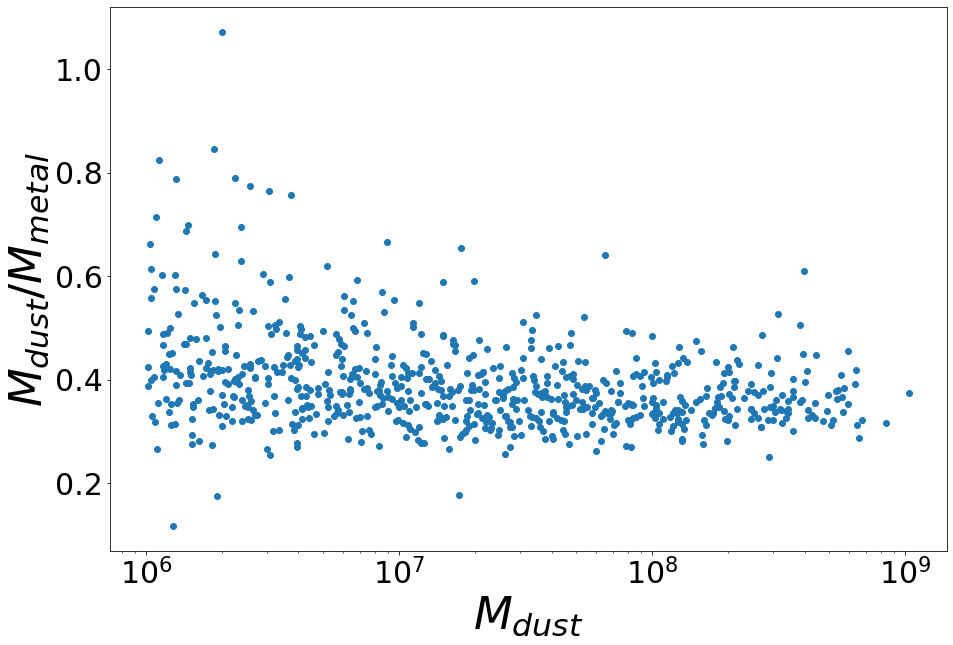

In [35]:
plt.scatter(df_dust.FractionStars*df_dust.HaloMass/h*1e10, df_dust.FractionDust/(df_dust.GasMetallicity*df_dust.FractionGas))
plt.xscale('log')
plt.ylabel(r'$M_{dust}/M_{metal}$', size=45)
plt.xlabel(r'$M_{dust}$', size=45)
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.rcParams["figure.figsize"] = (15, 10);

In [12]:
colors = ['orange', 'limegreen', 'mediumvioletred']
colors = ['C0', 'C1', 'C2']

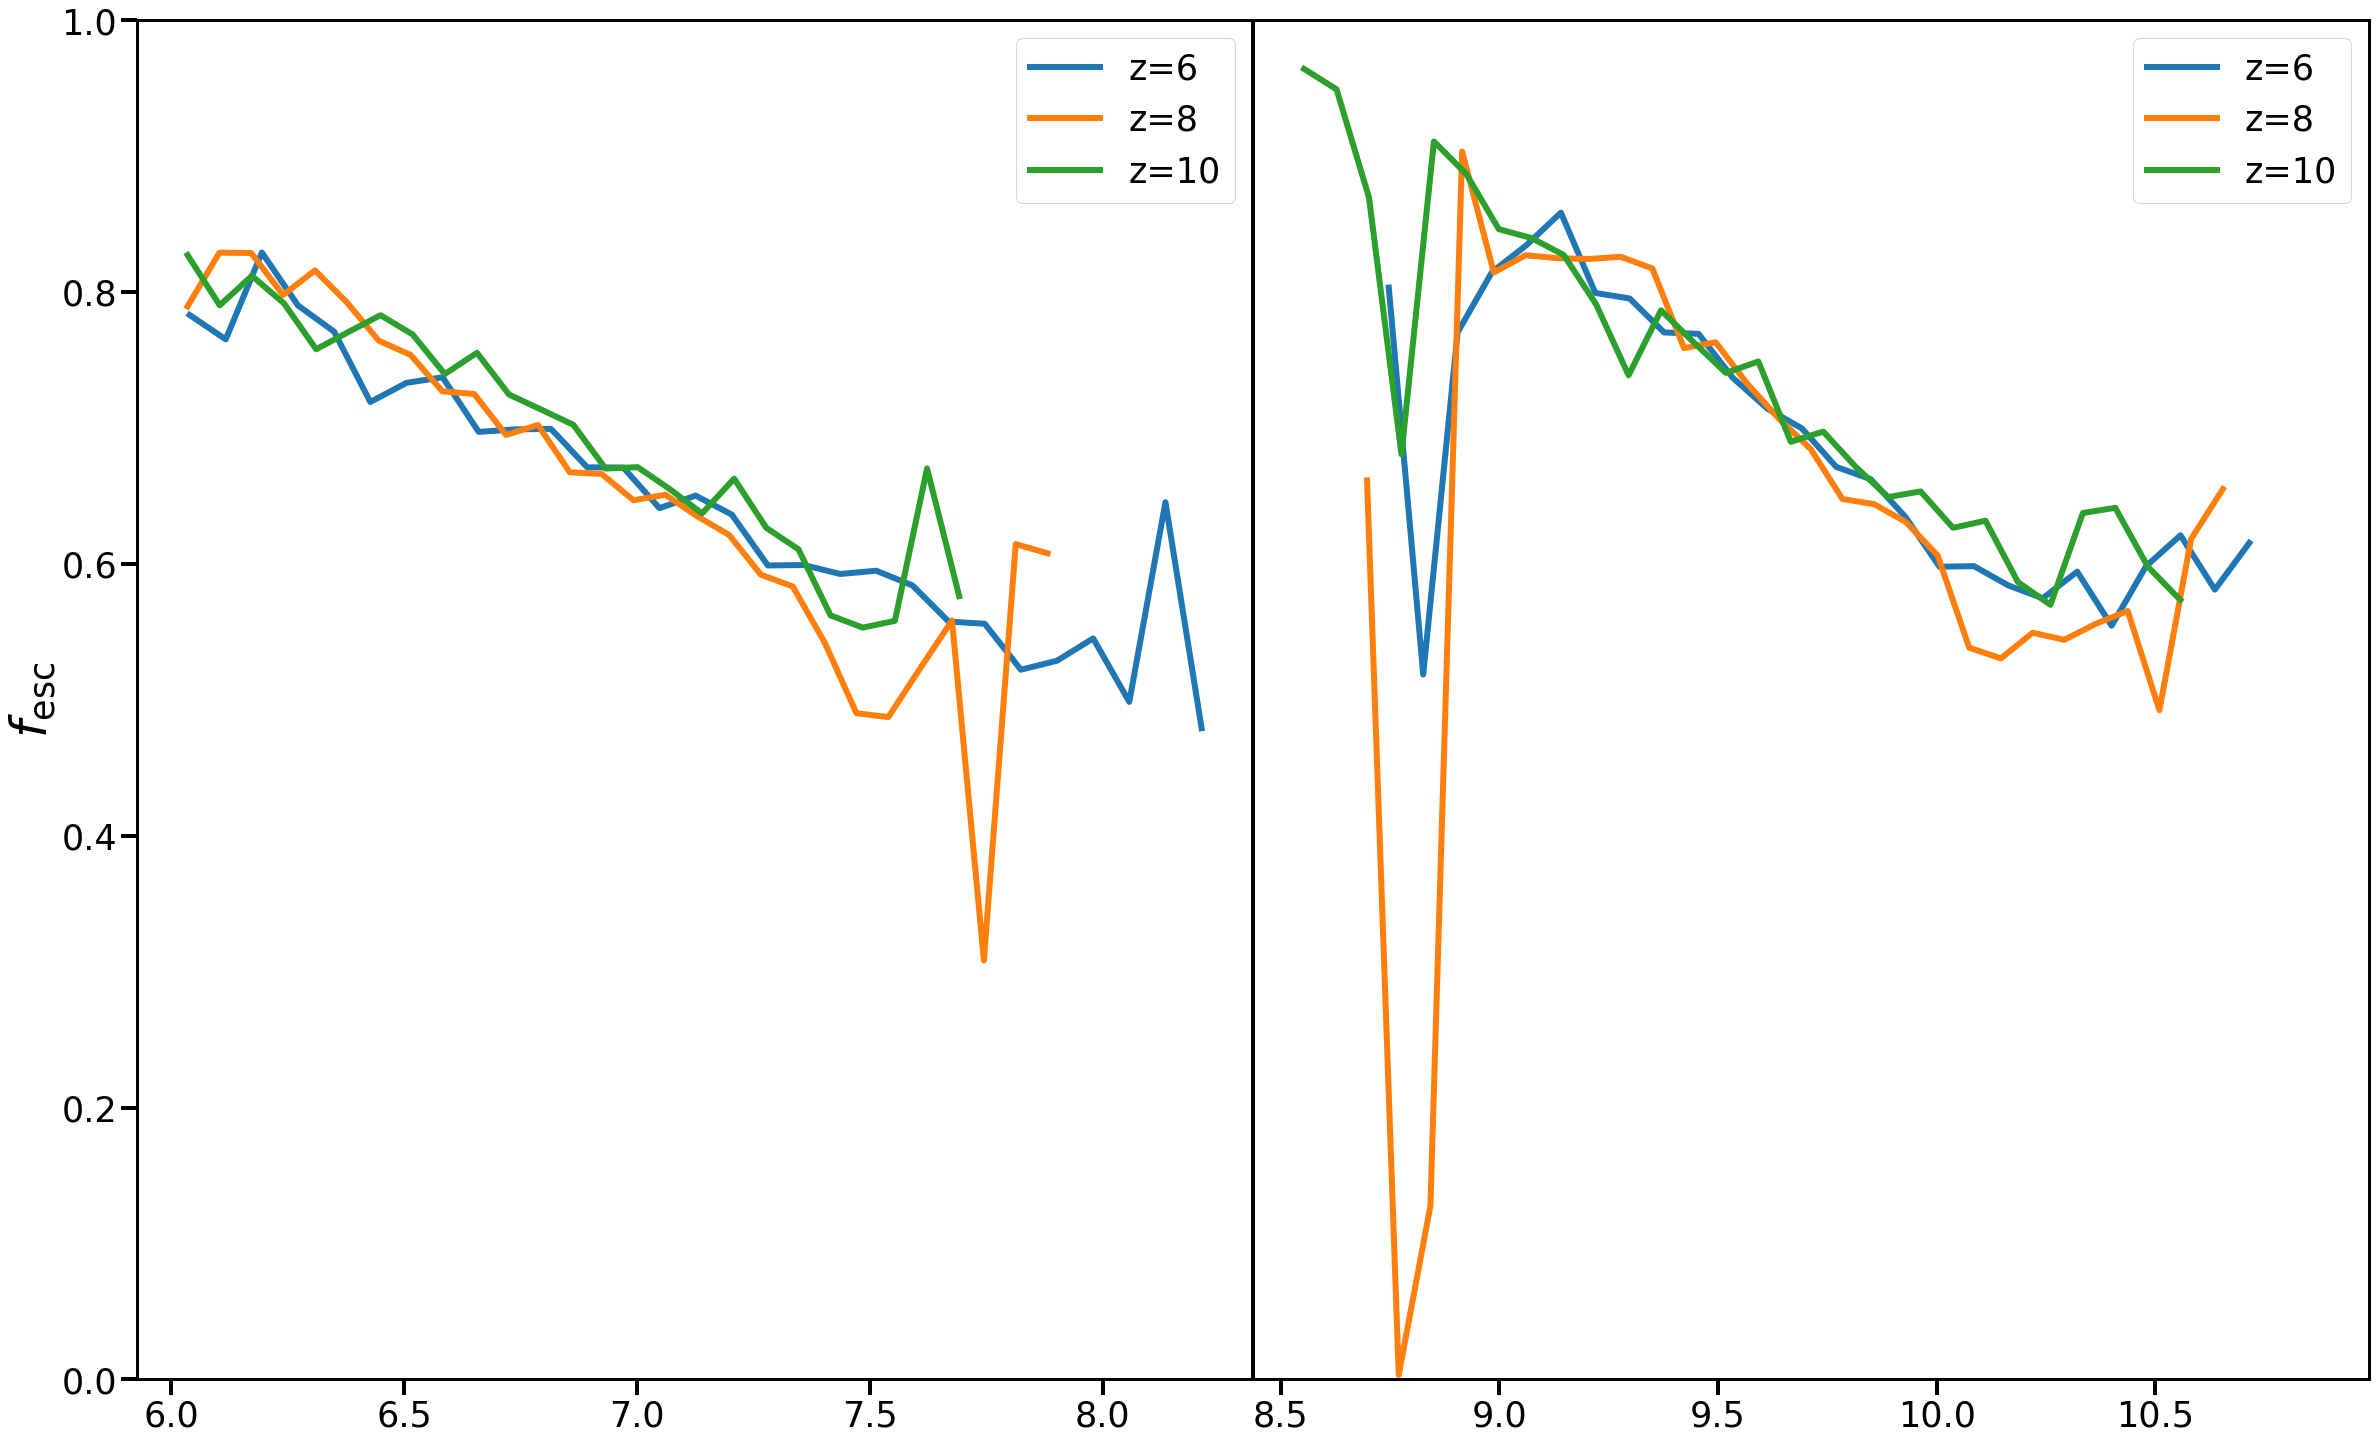

In [54]:
plot_scatter(df, halo_prop='both', bins=30, include_frac=False, include_var=False, threshold=1e-2, mode='mean', save=True, lin=True, include_galaxy=True, colors=colors, 
             lum_weighted=True, z_fracs=True)

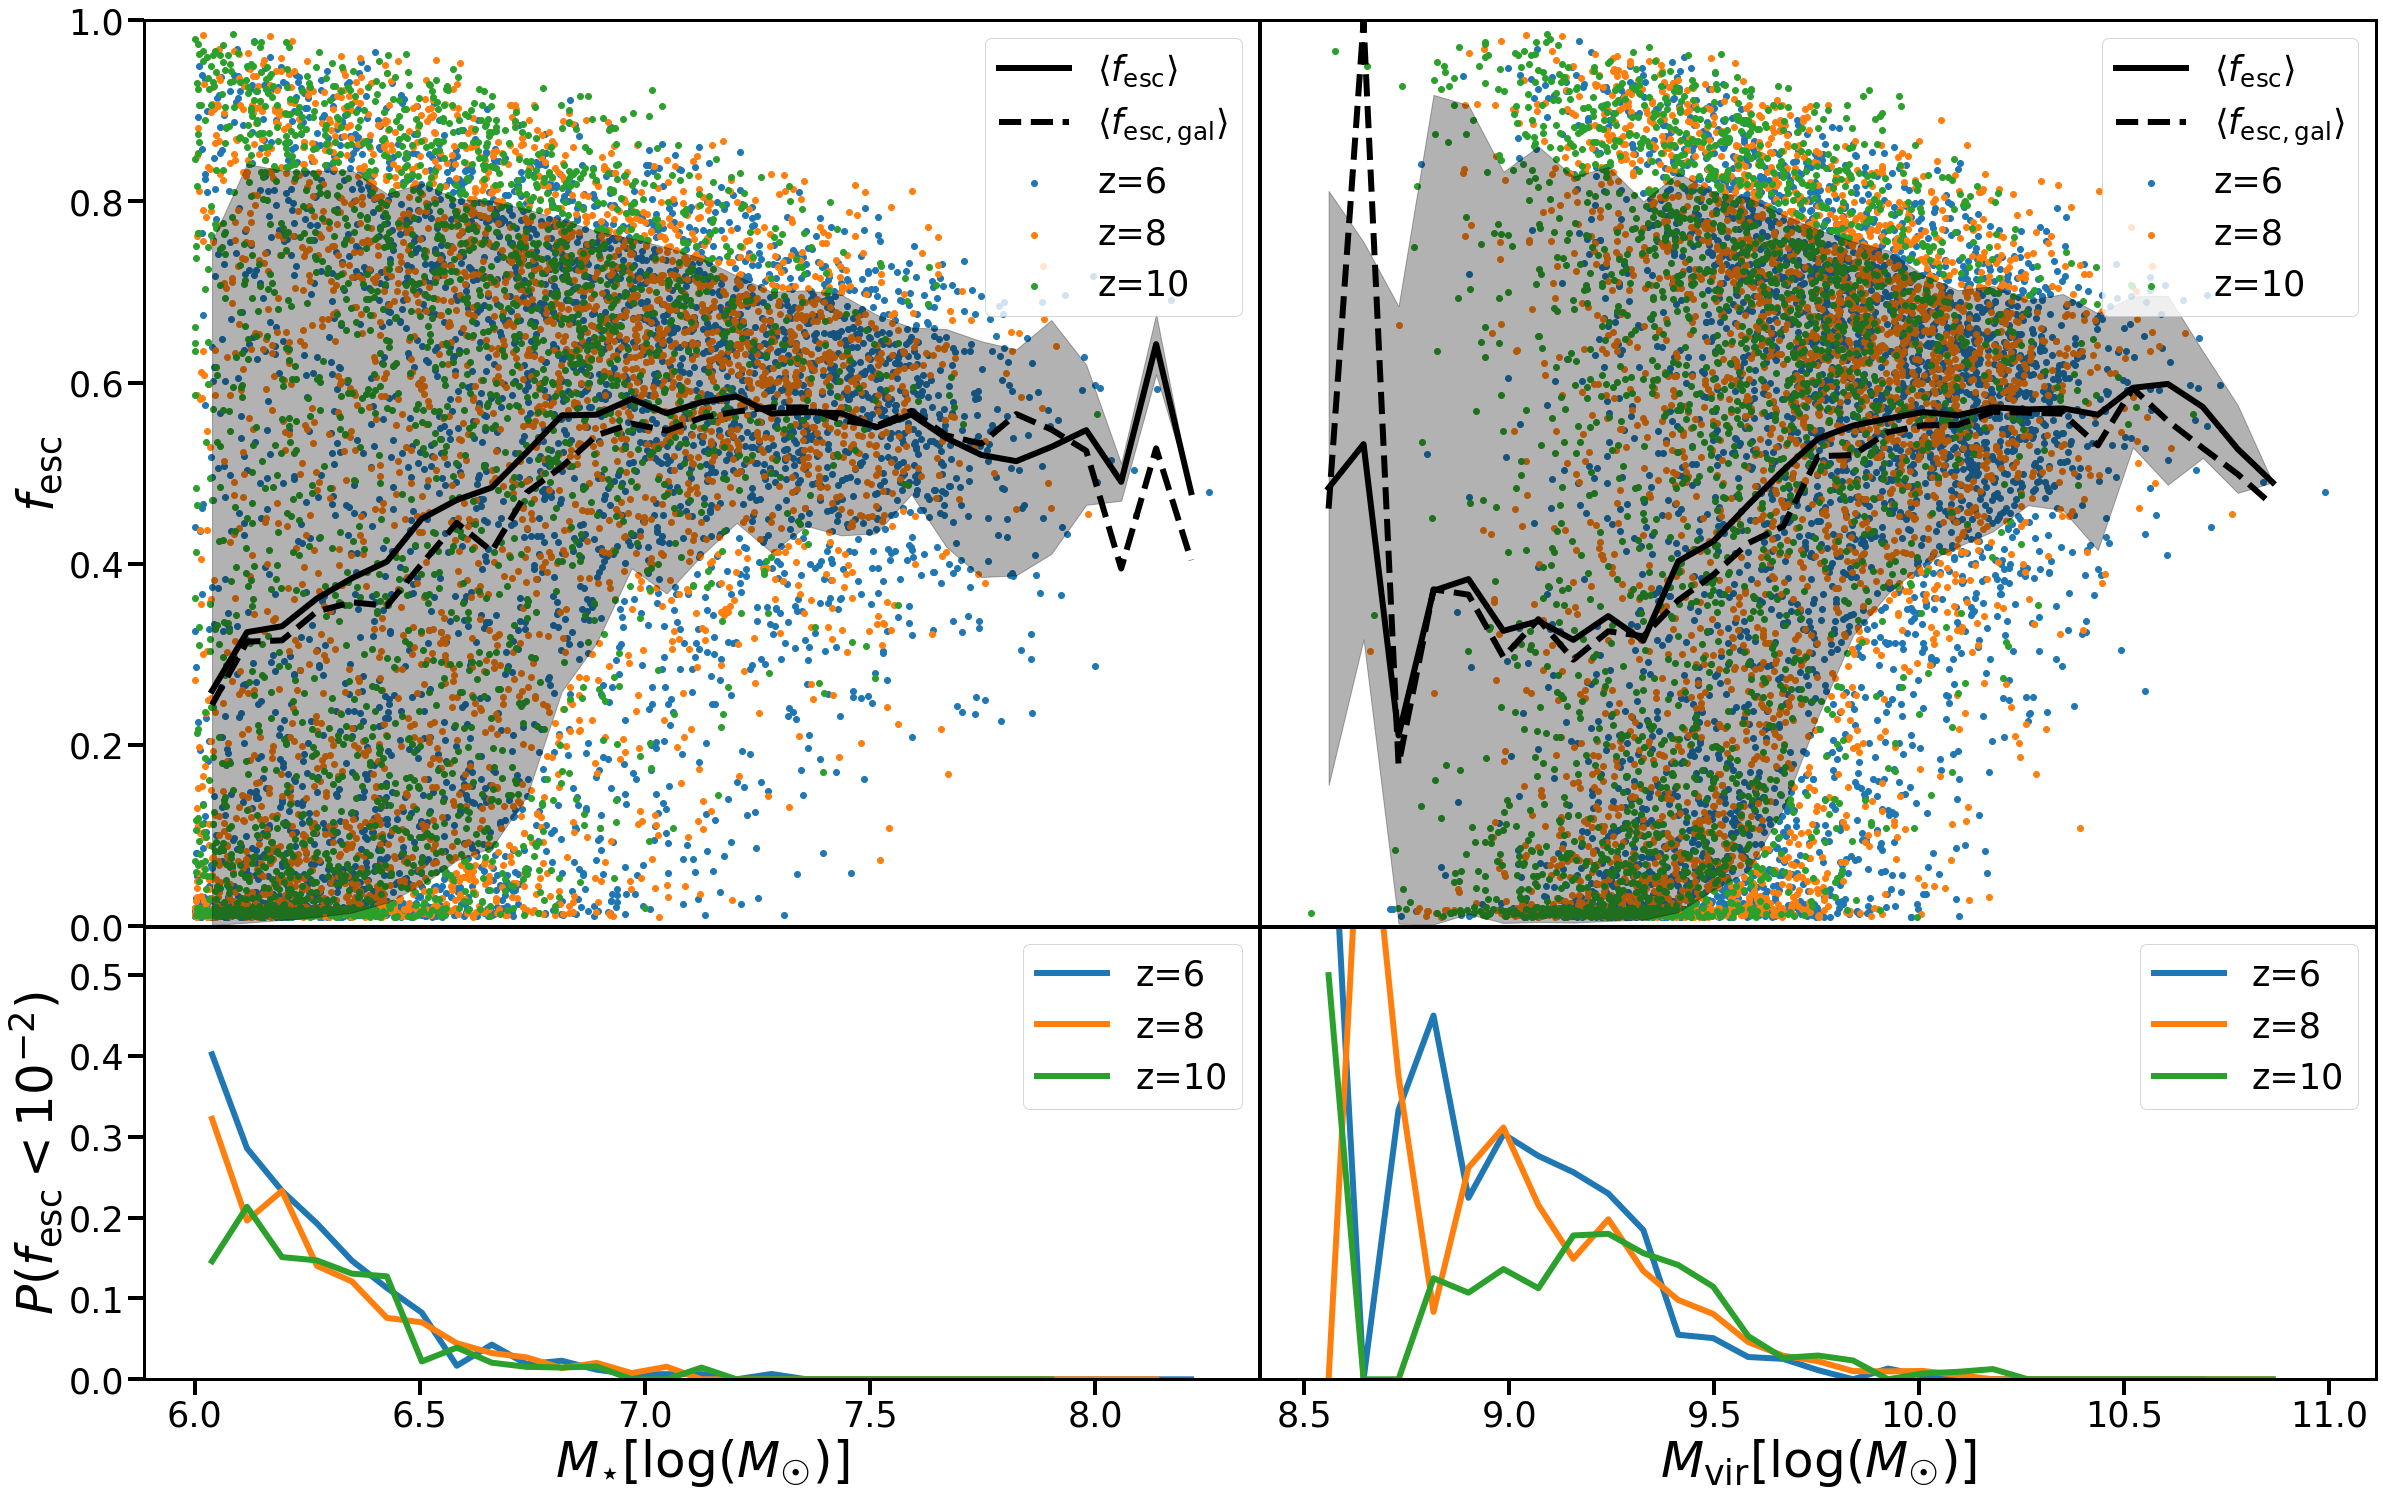

In [82]:
plot_scatter(df, halo_prop='both', bins=30, include_frac=True, include_var=False, threshold=1e-2, mode='mean', save=True, lin=True, include_galaxy=True, colors=colors)

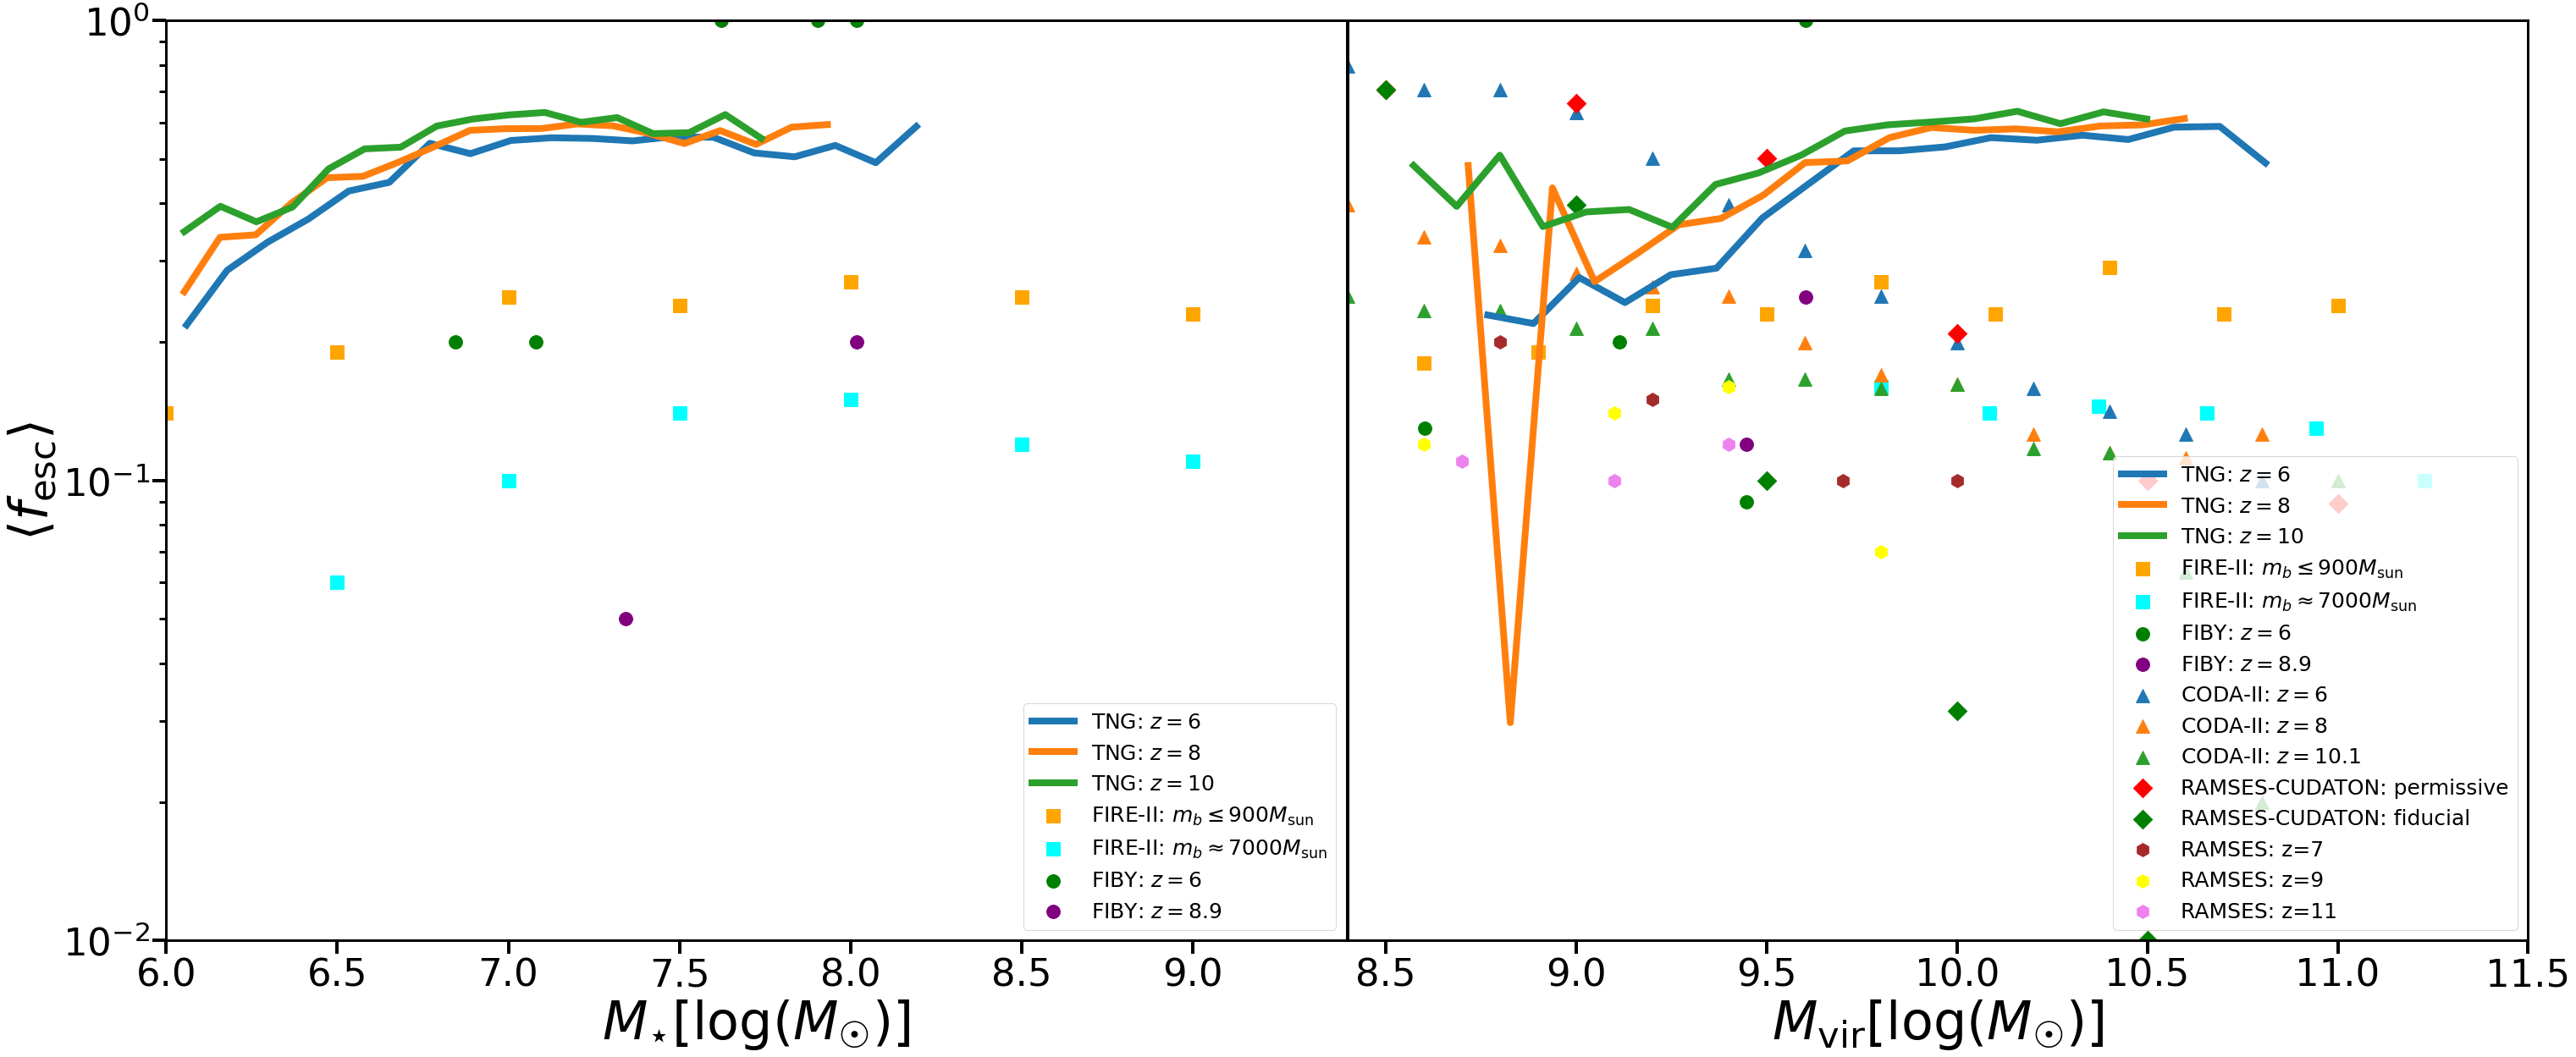

In [63]:
plot_lit_comparison(df, comparison, halo_prop='both', bins=20, mode='mean', save=True, lin=False, include_subgrid=False)

In [9]:
plot_lit_comparison(df, comparison, halo_prop='HaloMass', bins=20, mode='mean', save=False, lin=False, include_subgrid=False)

NameError: name 'df' is not defined

In [12]:
df_dust = pd.read_pickle('dfs/new_dust.pickle')

In [13]:
df_intersection = df.merge(df_dust[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('_no_dust', '_dust'))

In [14]:
colors=['C0', 'C1', 'C2']

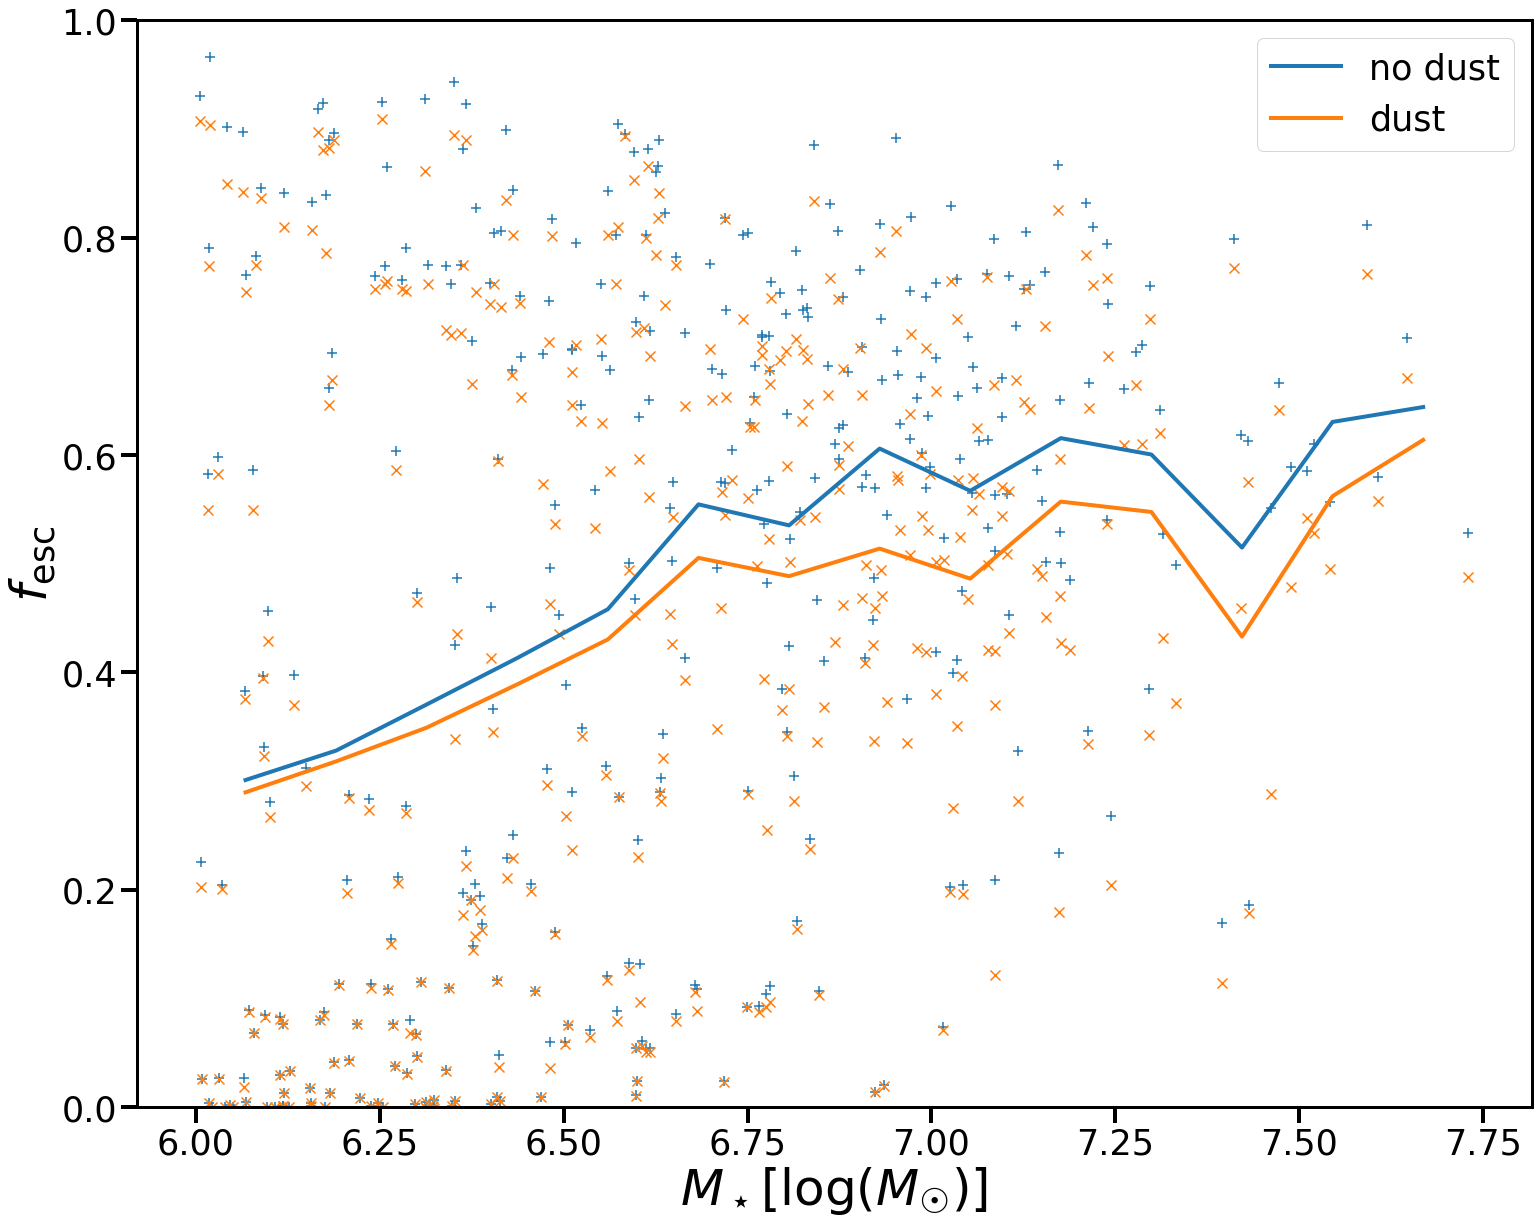

In [28]:
plot_dust_comparison(df_intersection, runs=['no_dust', 'dust'], halo_prop='StarMass', bins=15, mode='mean', scatter=True,
                         save=True, lin=True, residual=False, with_z=False, colors=colors)

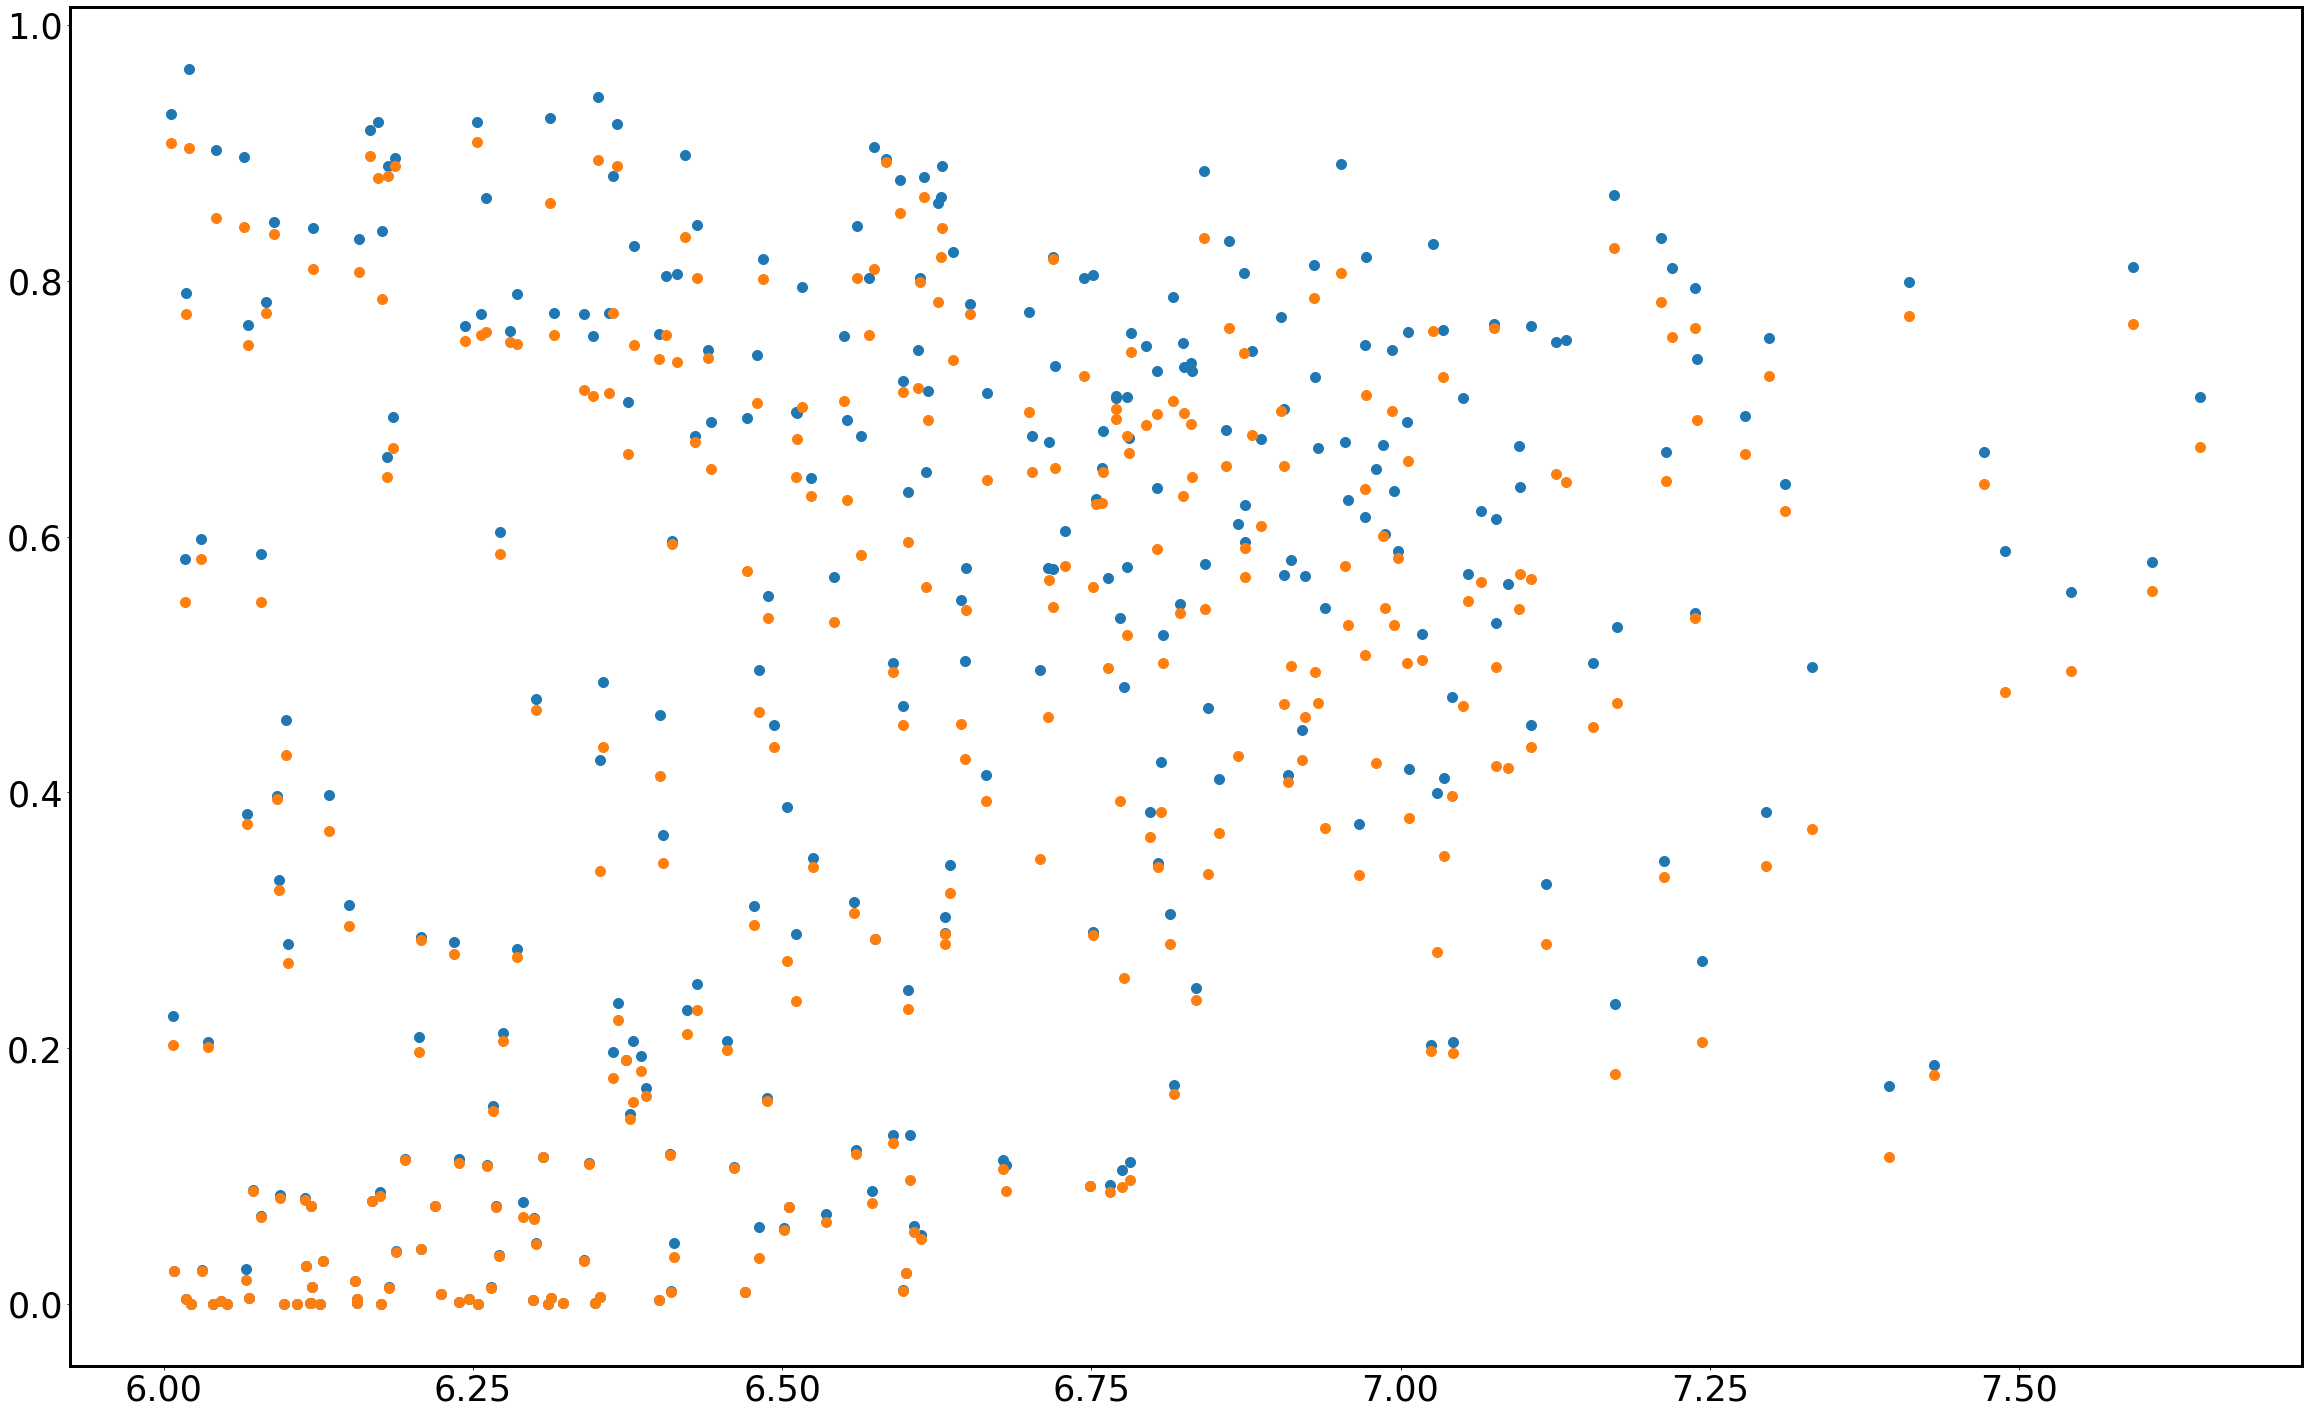

In [136]:
plt.scatter(np.log10(df_intersection.StarMass*1e10/h), df_intersection.f_esc_no_dust, s=100)
plt.scatter(np.log10(df_intersection.StarMass*1e10/h), df_intersection.f_esc_dust, s=100)

In [11]:
df_dust = pd.read_pickle('dfs/fid2d.pickle')
df_no_dust_full = pd.read_pickle('dfs/fid2.pickle')
df_dust_test = pd.read_pickle('dfs/dust_test.pickle')
df_dust_gdr = pd.read_pickle('dfs/dust_gdr.pickle')
update_df(df_dust)
update_df(df_no_dust_full552392)
update_df(df_dust_test)
update_df(df_dust_gdr)

In [85]:
df_intersection = df_no_dust_full.merge(df_dust[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('_no_dust', '_dust'))
df_intersection = df_intersection.merge(df_dust_test[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('','_dust_test'))
df_intersection = df_intersection.merge(df_dust_gdr[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('','_dust_gdr'))
df_intersection['f_esc_dust_test'] = df_intersection['f_esc']
update_df(df_intersection)

In [86]:
runs = ['no_dust', 'dust', 'dust_test', 'dust_gdr']

In [87]:
df_intersection.keys()

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'HaloRadii', 'f_esc_no_dust', 'f_esc_0_2',
       'Temperature', 'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass',
       'BHGrowth', 'SFR', 'density', 'clumping', 'per_freq', 'per_source',
       'emitted_photons', 'escaped_photons', 'frequencies', 'n_iterations',
       'per_freq_0_2', 'per_source_0_2', 'emitted_photons_0_2',
       'escaped_photons_0_2', 'frequencies_0_2', 'n_iterations_0_2',
       'Q0/HaloMass', 'R_v^3/HaloMass', 'StarMass', 'f_esc_dust', 'f_esc',
       'f_esc_dust_gdr', 'f_esc_dust_test'],
      dtype='object')

In [92]:
df_intersection['f_esc_dust_test']

0      0.085555
1      0.015916
2      0.077245
3      0.001436
4      0.133544
         ...   
184    0.114355
185    0.051220
186    0.048424
187    0.160672
188    0.012586
Name: f_esc_dust_test, Length: 189, dtype: float64

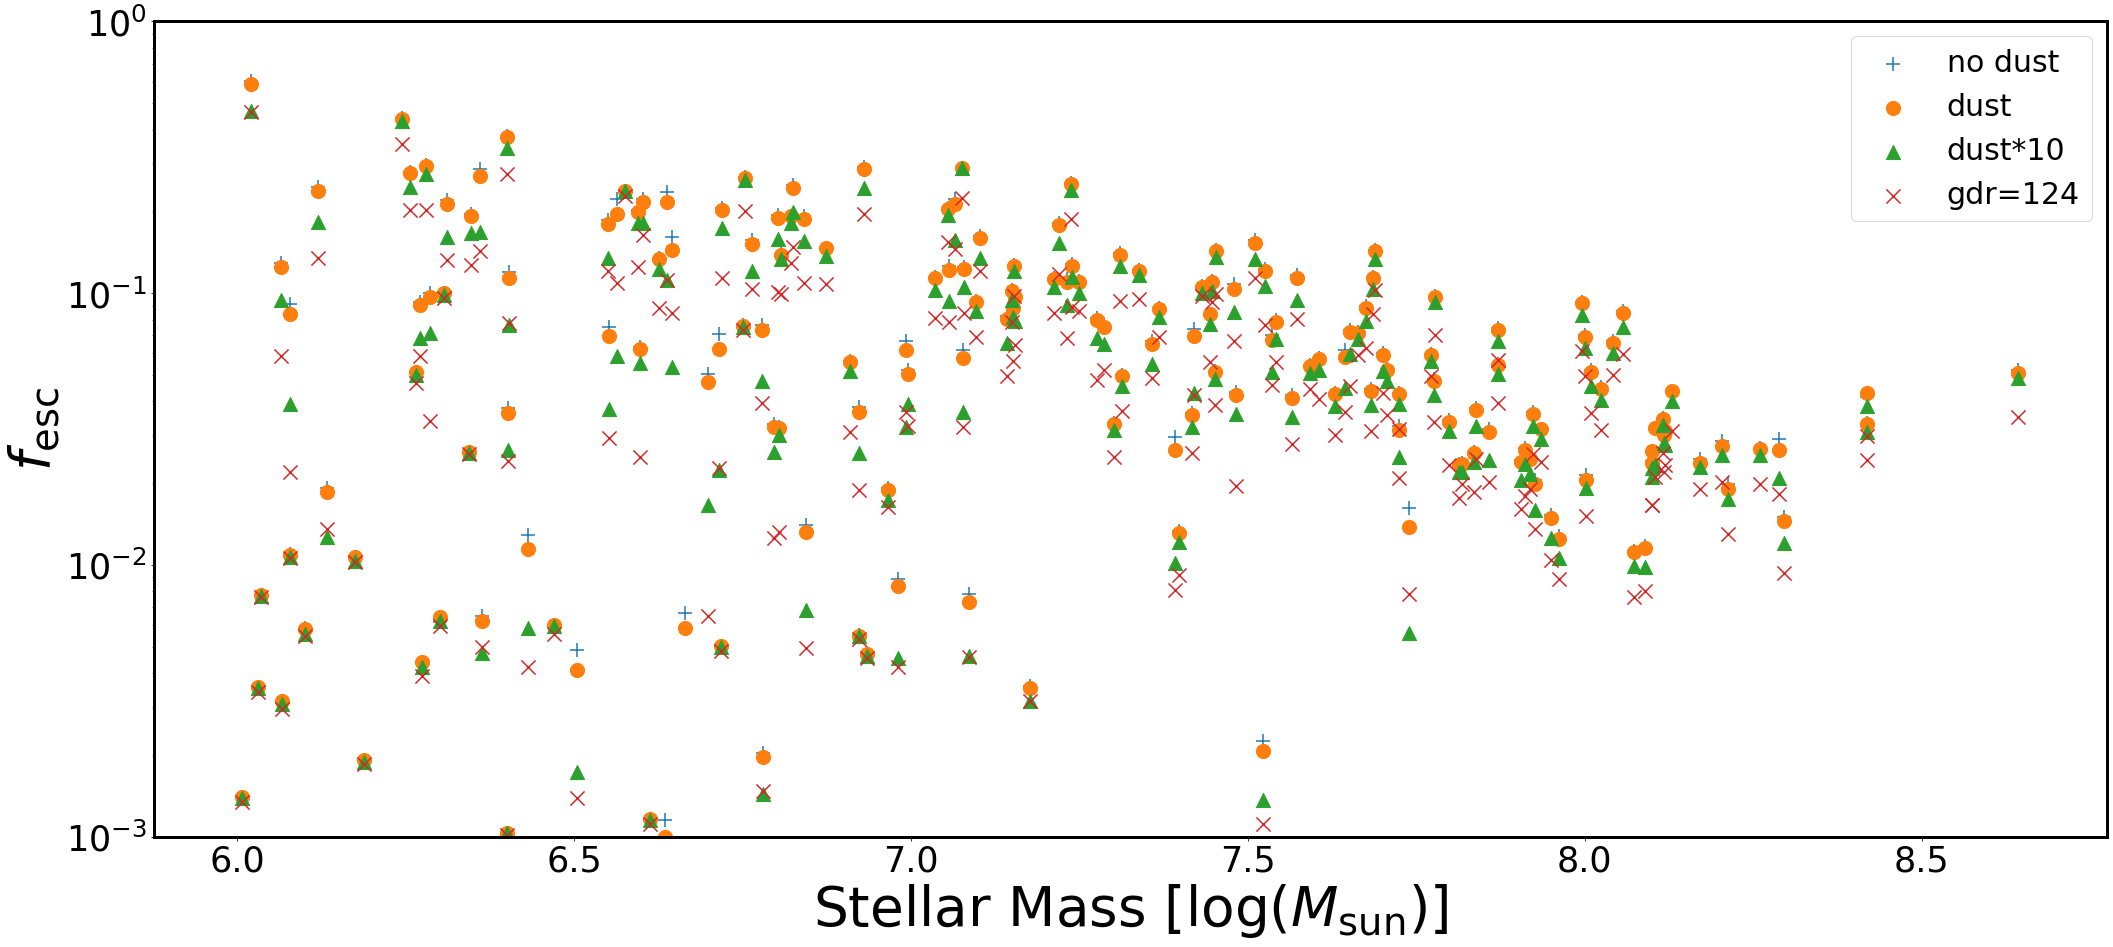

In [120]:
markersize = 200
x_values = np.log10(df_intersection['StarMass']*1e10/h)
plt.scatter(x_values, df_intersection['f_esc_no_dust'], marker='+', s=markersize, label='no dust')
plt.scatter(x_values, df_intersection['f_esc_dust'], marker='o', s=markersize, label='dust')
plt.scatter(x_values, df_intersection['f_esc_dust_test'], marker='^', s=markersize, label='dust*10')
plt.scatter(x_values, df_intersection['f_esc_dust_gdr'], marker='x', s=markersize, label='gdr=124')
#plt.scatter(df_dust_test['StarMass'], df_dust_test['f_esc'])
#plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$f_\mathrm{esc}$', fontsize=55)
plt.xlabel(r'Stellar Mass [$\log(M_{\mathrm{sun}})$]', fontsize=55)
plt.legend(fontsize=30)
plt.ylim(1e-3, 1)
plt.rcParams["figure.figsize"] = (35, 15)
plt.figsave('/u/ivkos/analysis/plots/dust_tests.pdf');

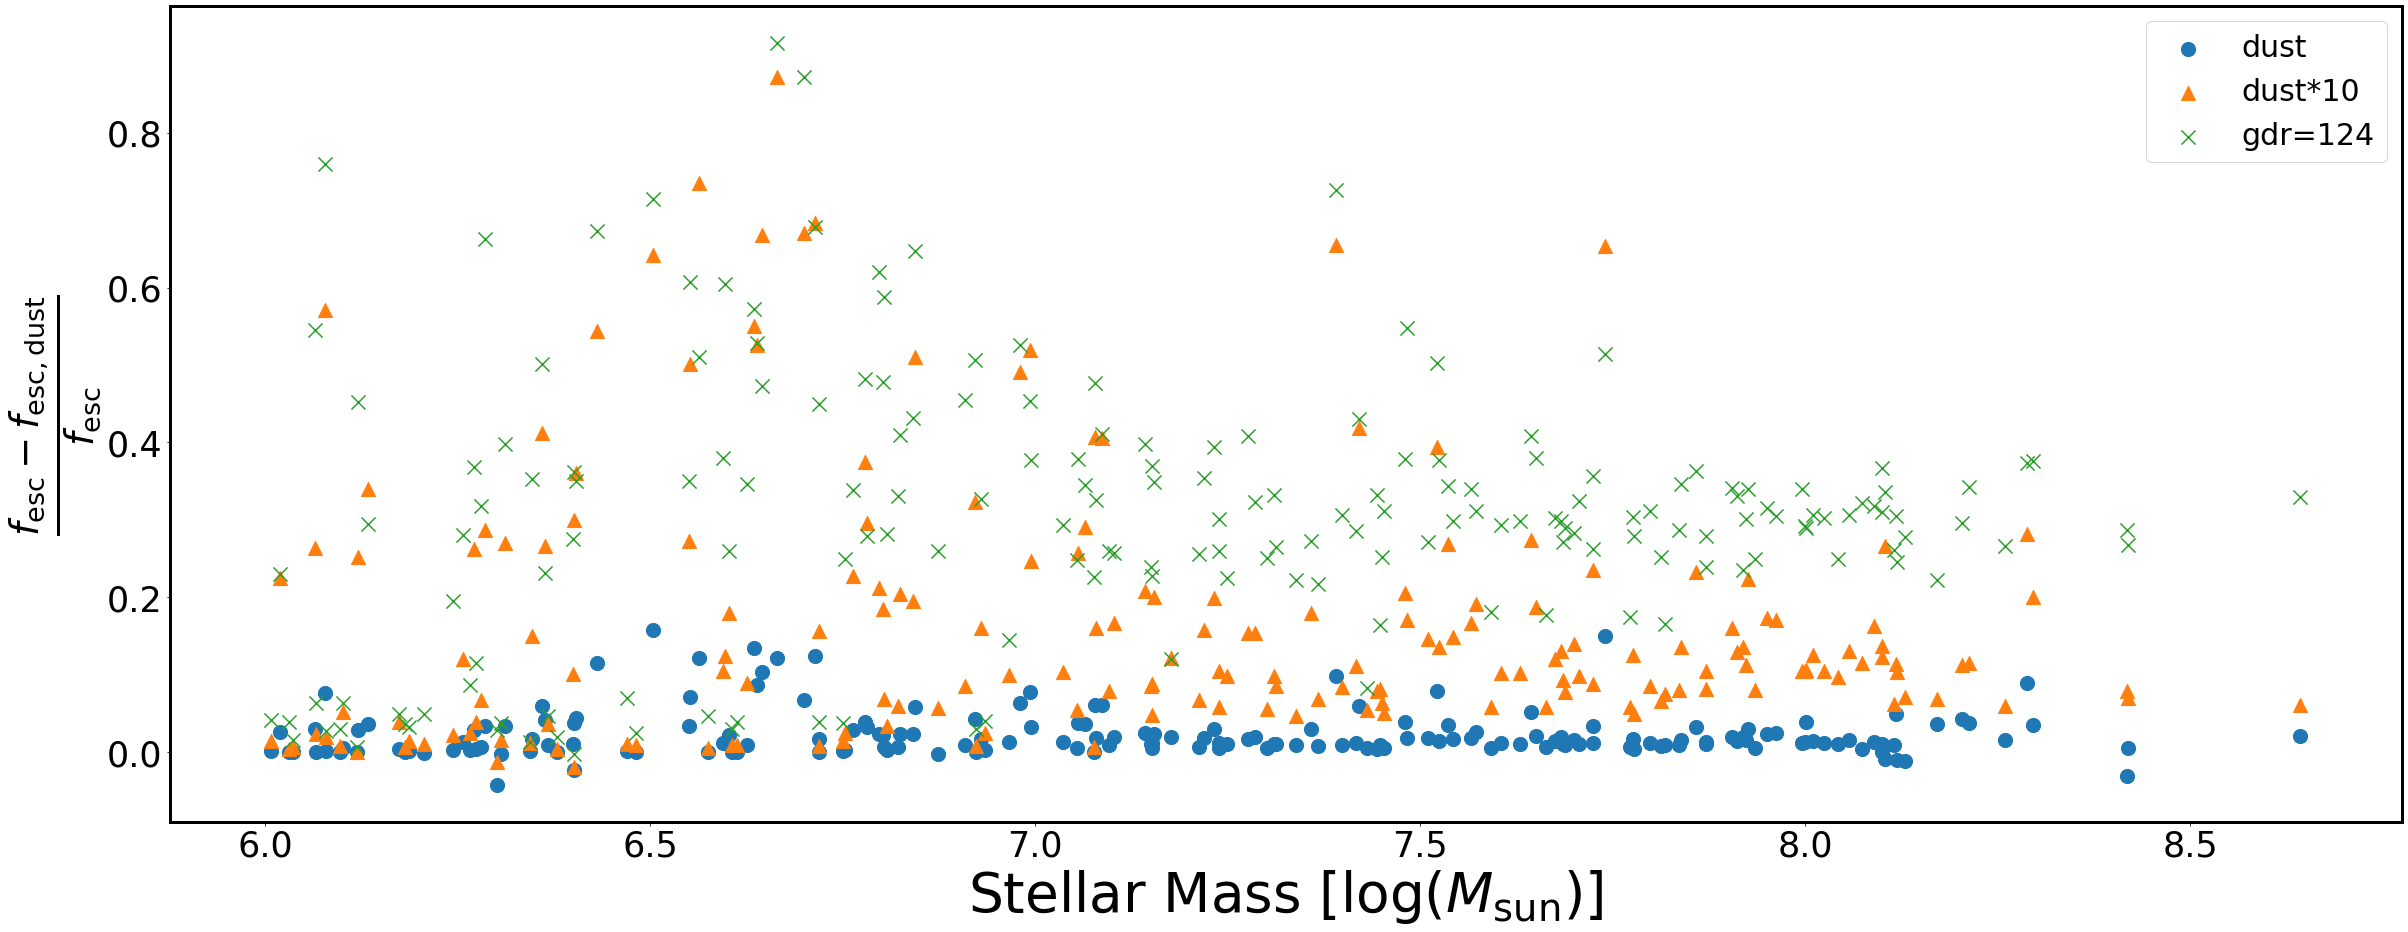

In [118]:
markersize = 200
x_values = np.log10(df_intersection['StarMass']*1e10/h)
#plt.scatter(x_values, df_intersection['f_esc_no_dust'], marker='+', s=markersize, label='no dust')
y_dust = (-df_intersection['f_esc_dust']+df_intersection['f_esc_no_dust'])/df_intersection['f_esc_no_dust']
plt.scatter(x_values, y_dust, marker='o', s=markersize, label='dust')

y_dust_test = (-df_intersection['f_esc_dust_test']+df_intersection['f_esc_no_dust'])/df_intersection['f_esc_no_dust']
plt.scatter(x_values, y_dust_test, marker='^', s=markersize, label='dust*10')

y_dust_gdr = (-df_intersection['f_esc_dust_gdr']+df_intersection['f_esc_no_dust'])/df_intersection['f_esc_no_dust']
plt.scatter(x_values, y_dust_gdr, marker='x', s=markersize, label='gdr=124')
#plt.scatter(df_dust_test['StarMass'], df_dust_test['f_esc'])
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'$\frac{f_\mathrm{esc}-f_\mathrm{esc, dust}}{f_\mathrm{esc}}$', fontsize=55)
plt.xlabel(r'Stellar Mass [$\log(M_{\mathrm{sun}})$]', fontsize=55)
plt.legend(fontsize=30)
#plt.ylim(1e-3, 1)
plt.rcParams["figure.figsize"] = (35, 15)
/u/ivkos/analysis/plots/;

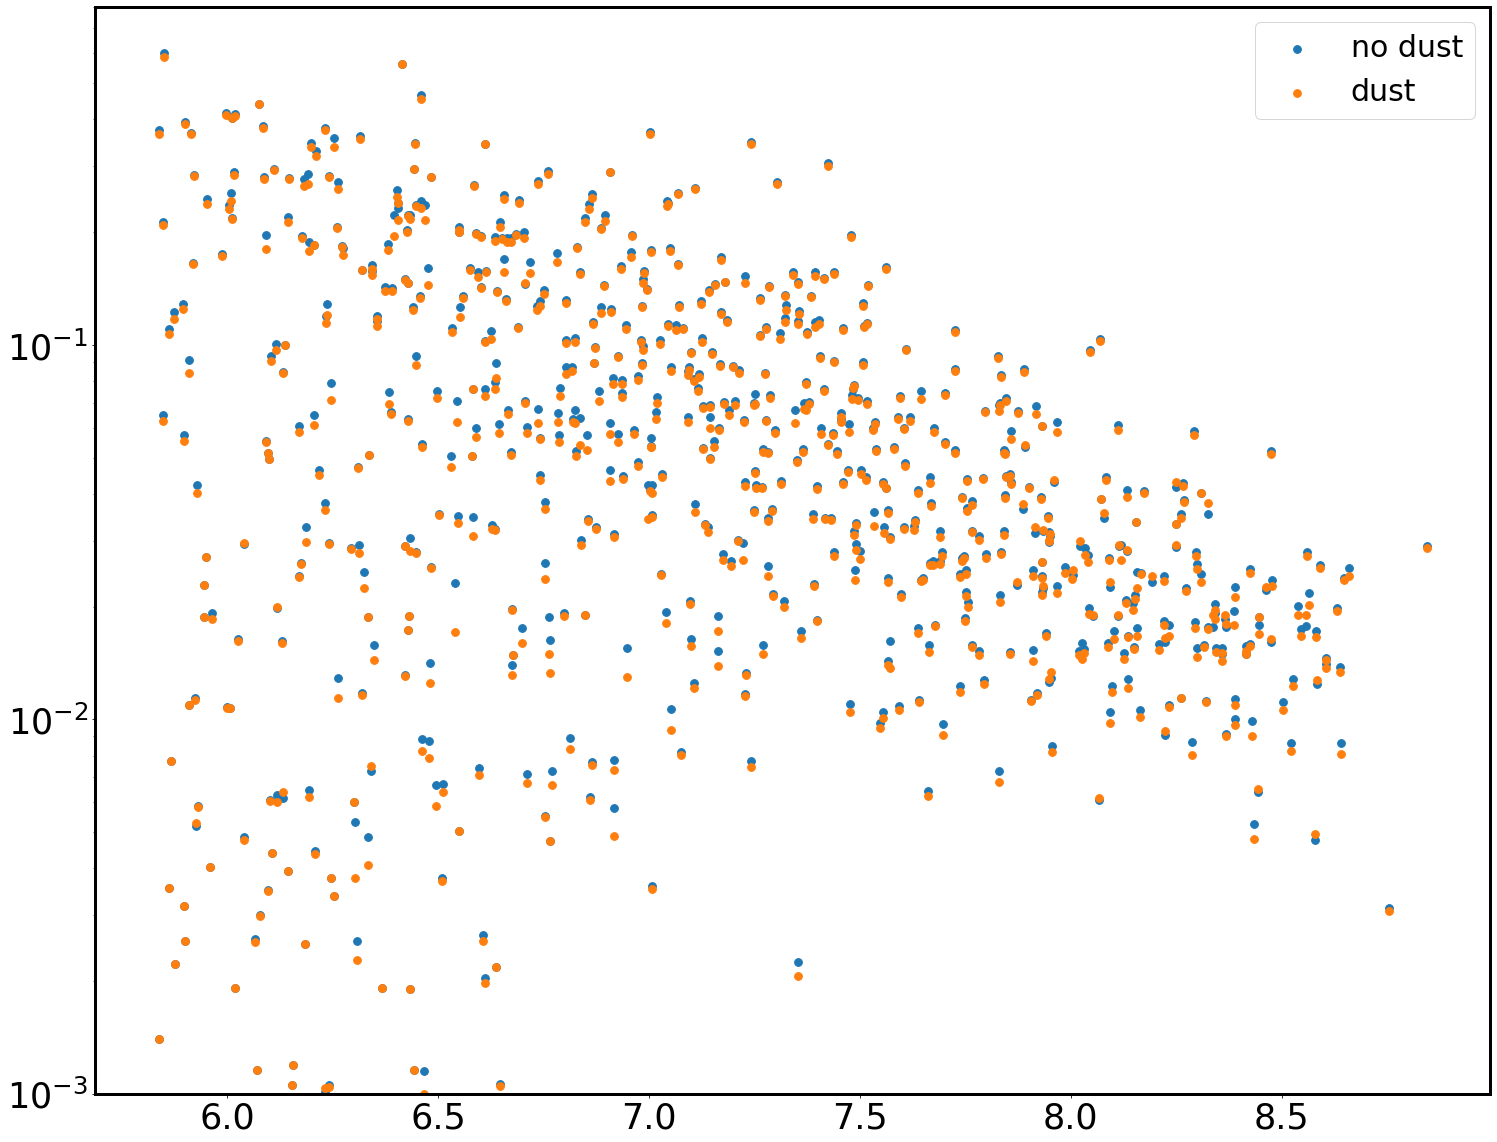

In [59]:
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_no_dust, s=60, label='no dust')
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_dust, s=60, label='dust')
plt.yscale('log')
plt.xlabel
plt.ylim(1e-3, 8e-1)
plt.legend(fontsize=30);

In [18]:
df.StarMass=df.StarMass*1e10/h

In [32]:
centers_6, means_6, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df[df.z==6], halo_prop='StarMass', 
                                                                                          bins=30, mode='mean', y_axis='f_esc')
centers_8, means_8, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df[df.z==8], halo_prop='StarMass', 
                                                                                          bins=30, mode='mean', y_axis='f_esc')
centers_10, means_10, quantile16, quantile84, error, variance, frac_small_arr = get_scatter(df[df.z==10], halo_prop='StarMass', 
                                                                                          bins=30, mode='mean', y_axis='f_esc')

In [41]:
test = np.array([0.22301074, 0.2290216 , 0.1944536 , 0.17902371, 0.1966658 ,
       0.20291286, 0.21013397, 0.18373226, 0.1765717 , 0.18469428,
       0.1618543 , 0.14212303, 0.13923907, 0.1231746 , 0.09821967,
       0.09380512, 0.0909887 , 0.10416171, 0.11446853, 0.06992348,
       0.04718057, 0.02682576, 0.06862086, 0.04262337, 0.02754916,
       0.0229977 , 0.03328685])

In [42]:
print(np.average(means_6))
print(np.average(means_8))
print(np.average(test))

0.093136226778838
0.10203770766151987
0.12545418518518517


In [17]:
test = pd.read_pickle('dfs/full_esc.pickle')

In [18]:
len(test)

9552

In [22]:
new_results = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(new_results)

In [23]:
len(new_results)

8440

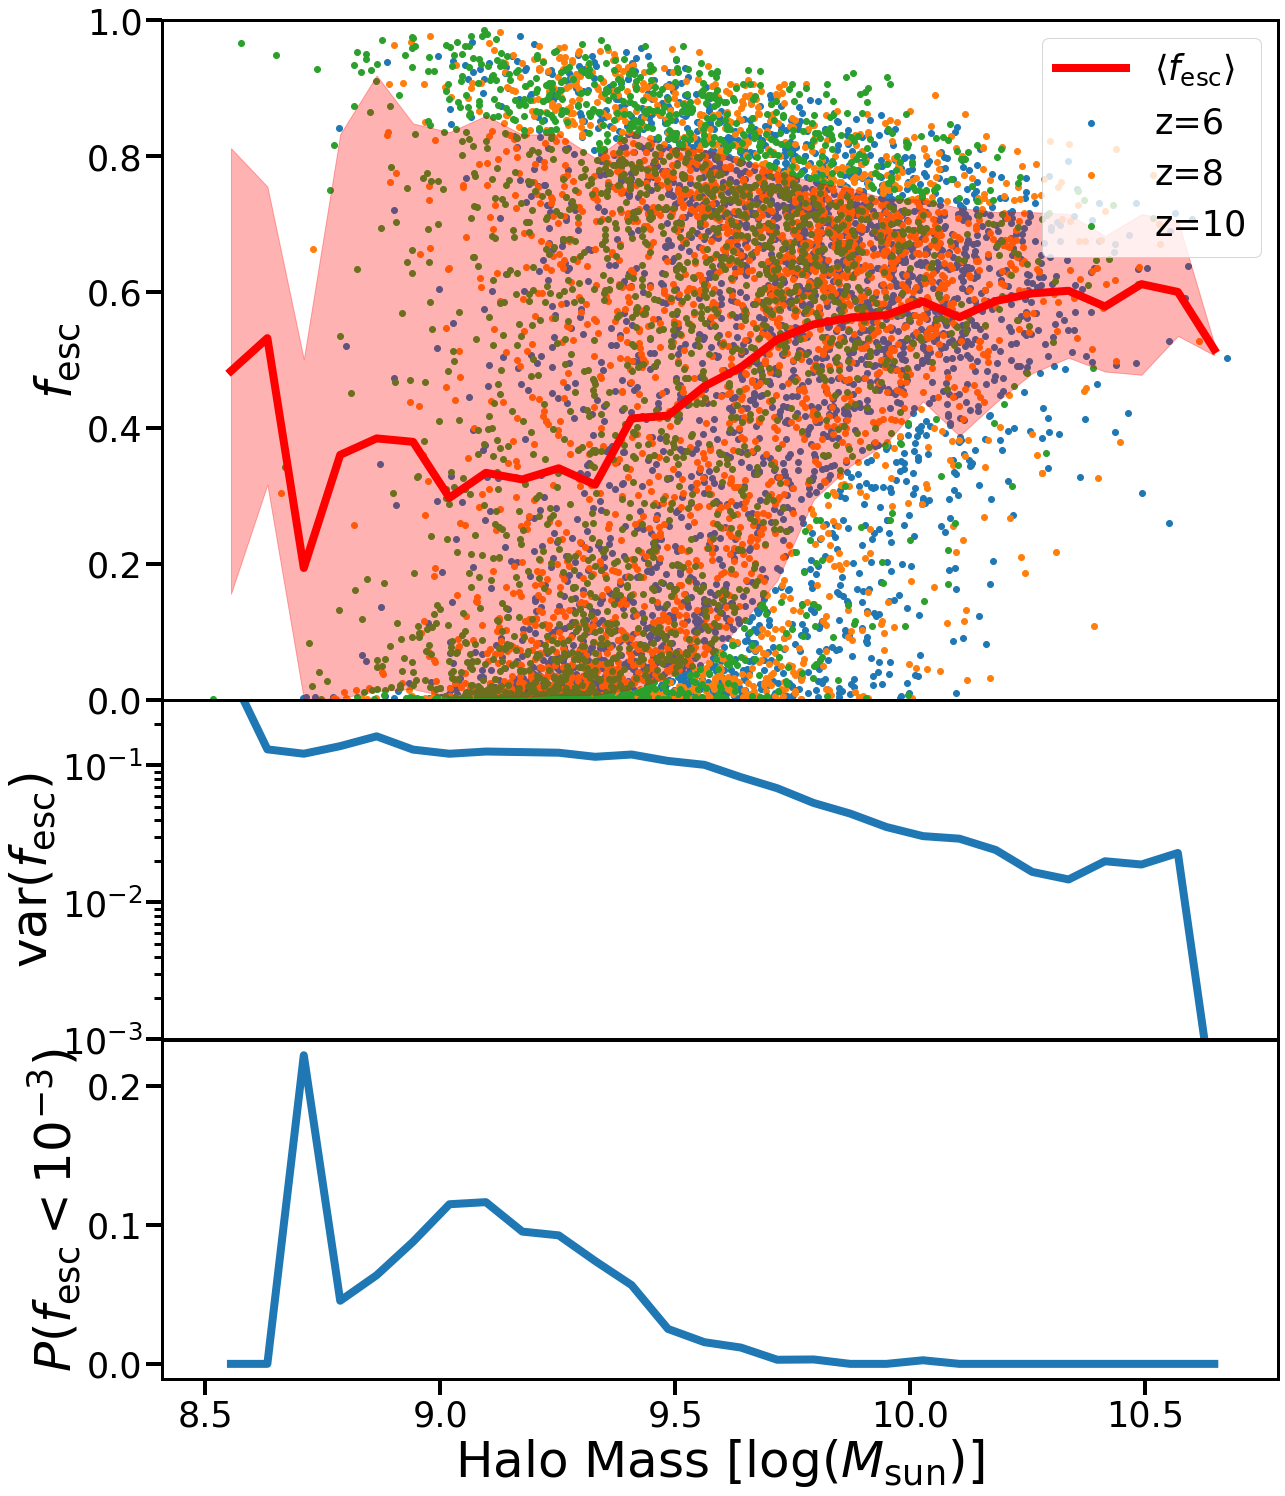

In [34]:
plot_scatter(new_results, halo_prop='HaloMass', bins=30, mode='mean', threshold=1e-3, 
                 include_frac=True, save=True, lin=True, galaxy=False, include_galaxy=False, include_var=True)

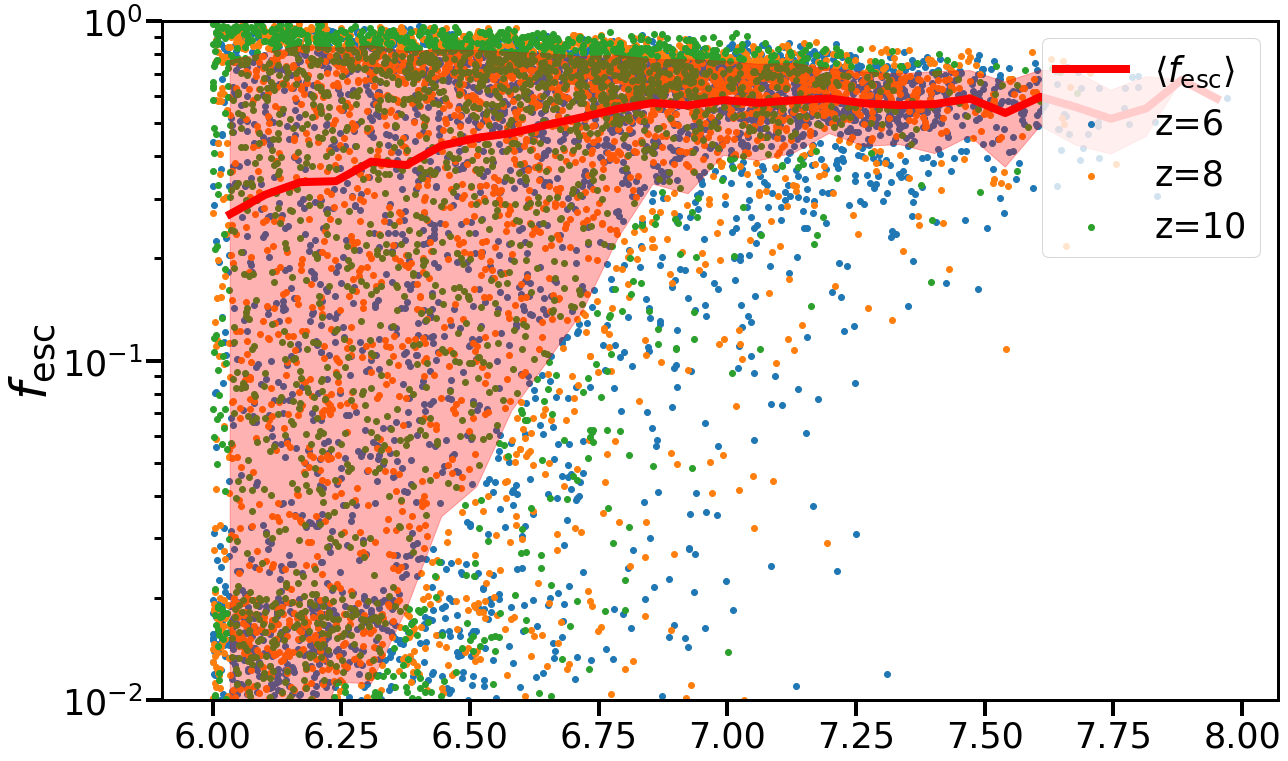

In [25]:
plot_scatter(new_results, halo_prop='StarMass', bins=30, mode='mean', threshold=1e-2, 
                 include_frac=False, save=False, lin=False, galaxy=False, include_galaxy=False, include_var=False)

In [10]:
new_results = pd.read_pickle('dfs/esc_analysis.pickle')
update_df(new_results)

In [42]:
new_dust = pd.read_pickle('dfs/new_dust.pickle')
update_df(new_dust)

In [44]:
df_intersection = new_results.merge(new_dust[['ID','z','f_esc']], on=['ID', 'z'], how='inner', suffixes=('_no_dust', '_dust'))

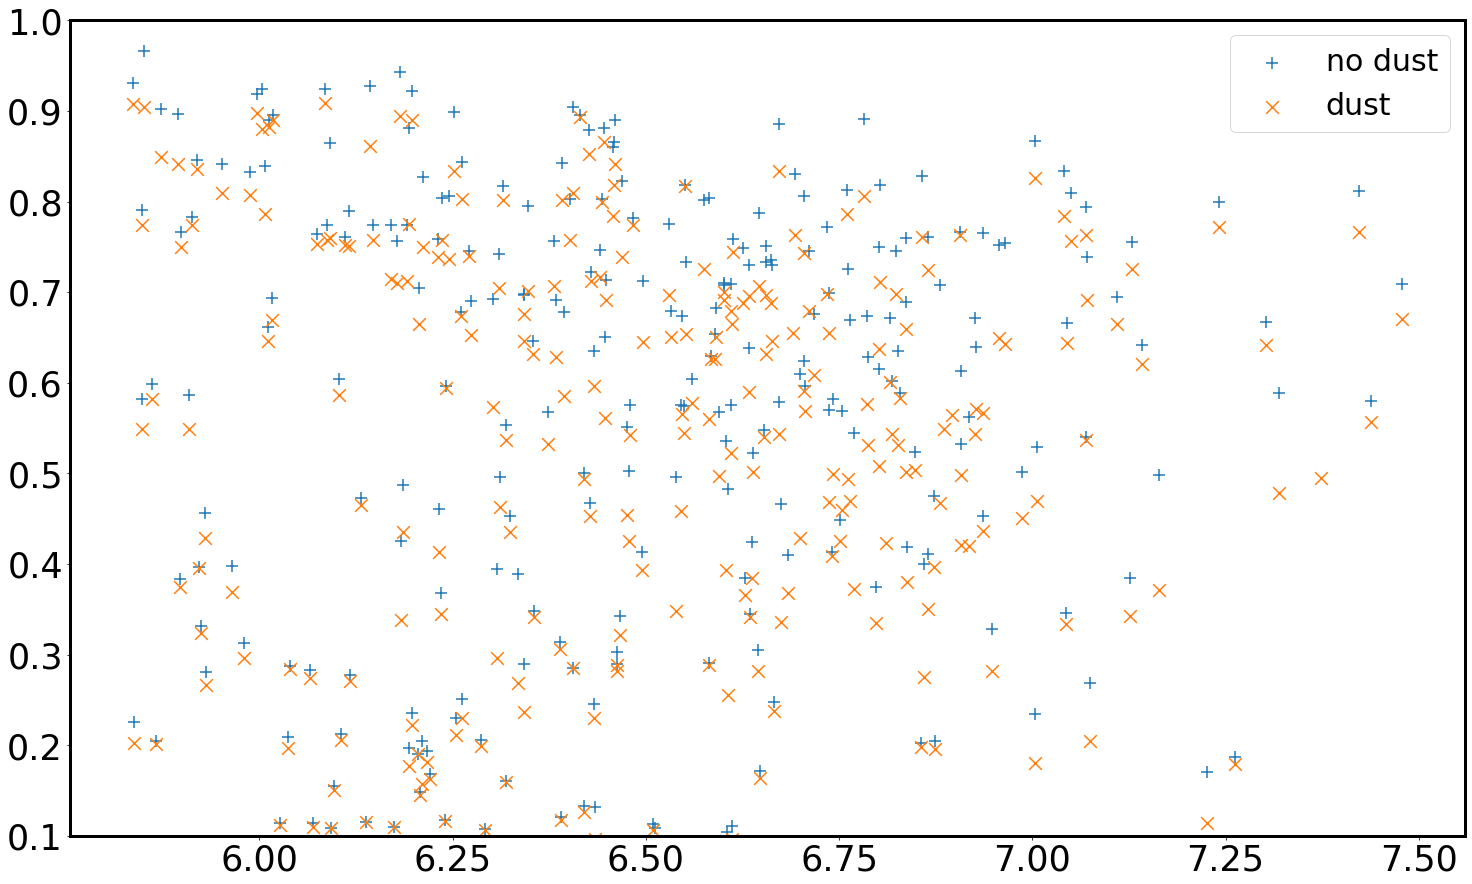

In [56]:
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_no_dust, s=160, marker='+', label='no dust')
plt.scatter(np.log10(df_intersection.StarMass*1e10), df_intersection.f_esc_dust, s=160, marker='x', label='dust')
#plt.yscale('log')
plt.xlabel
plt.ylim(1e-1, 1)
plt.rcParams["figure.figsize"] = (25, 15)
plt.legend(fontsize=30);

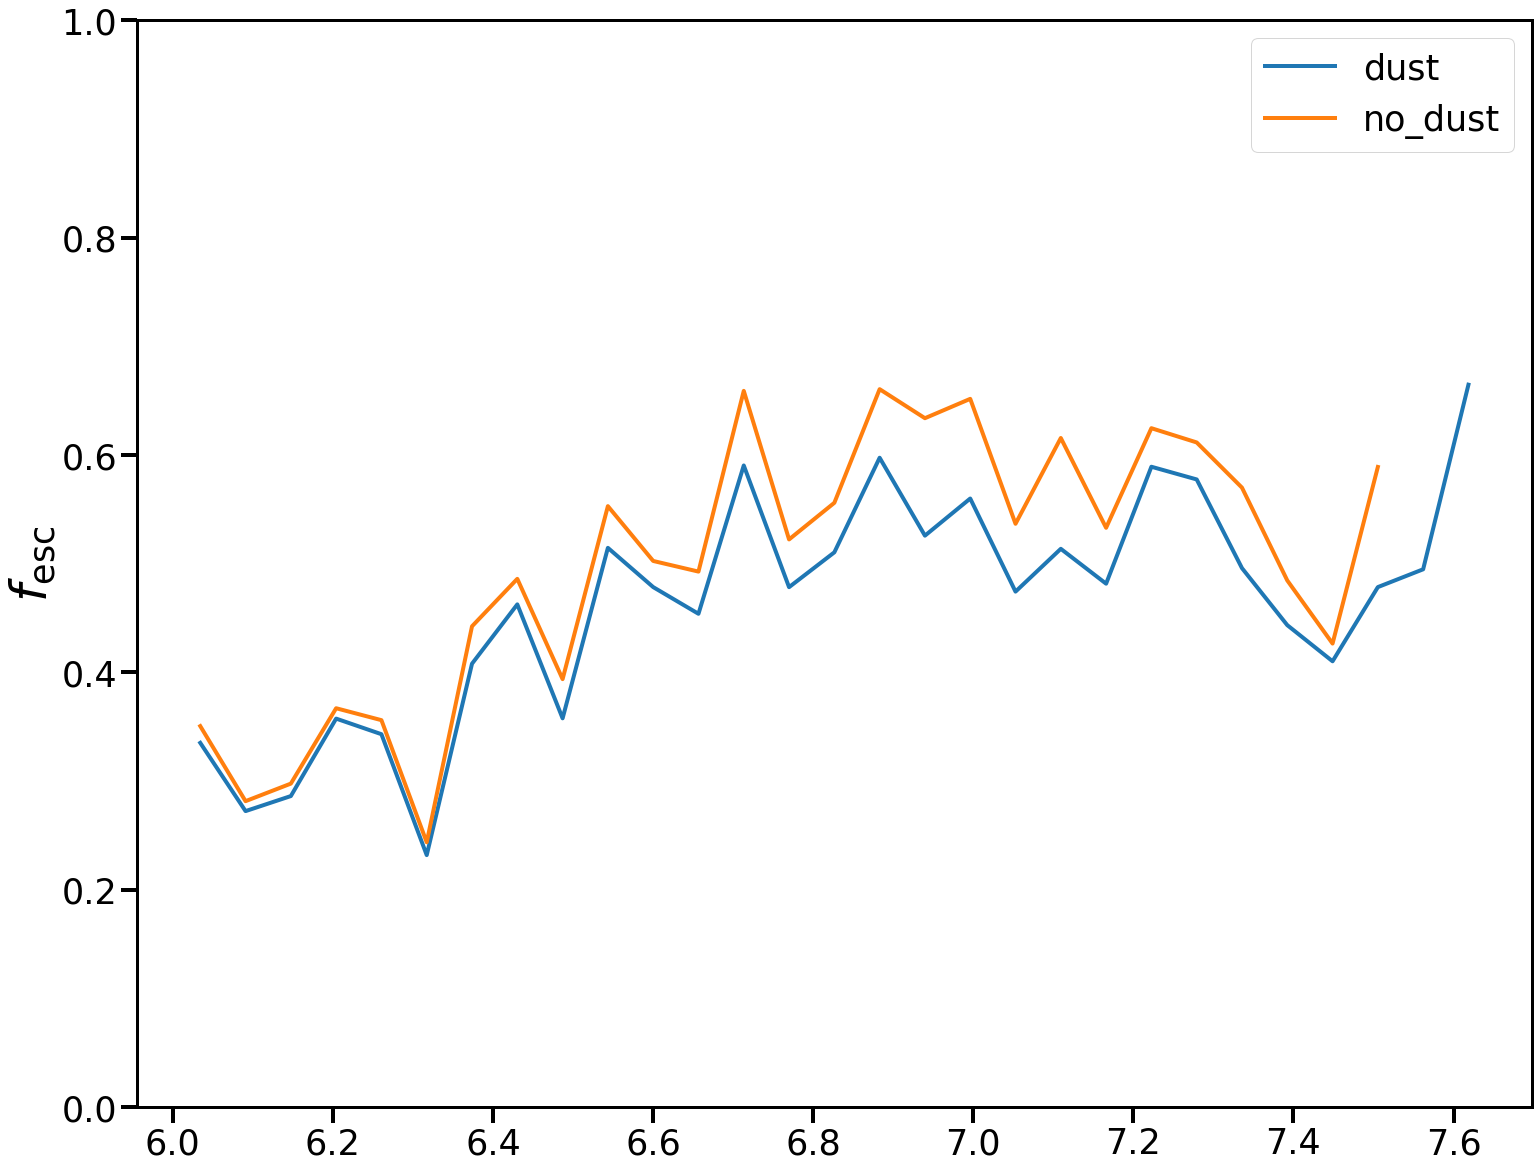

In [87]:
plot_dust_comparison(df_intersection, runs=['dust', 'no_dust'], halo_prop='StarMass', bins=30, mode='mean', scatter=False,
                         save=False, lin=True, galaxy=False, residual=False, with_z=False)

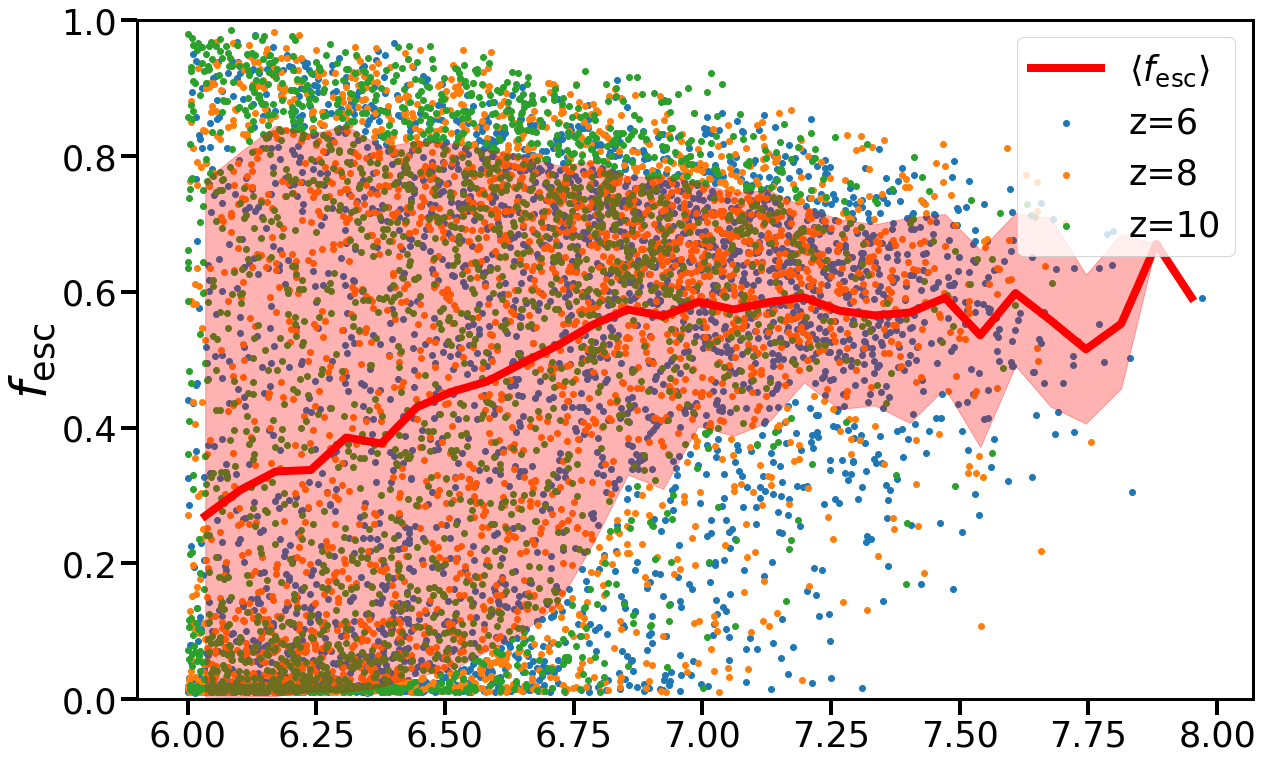

In [12]:
plot_scatter(new_results, halo_prop='StarMass', bins=30, mode='mean', threshold=1e-2, 
                 include_frac=False, save=False, lin=True, galaxy=False, include_galaxy=False, include_var=False)

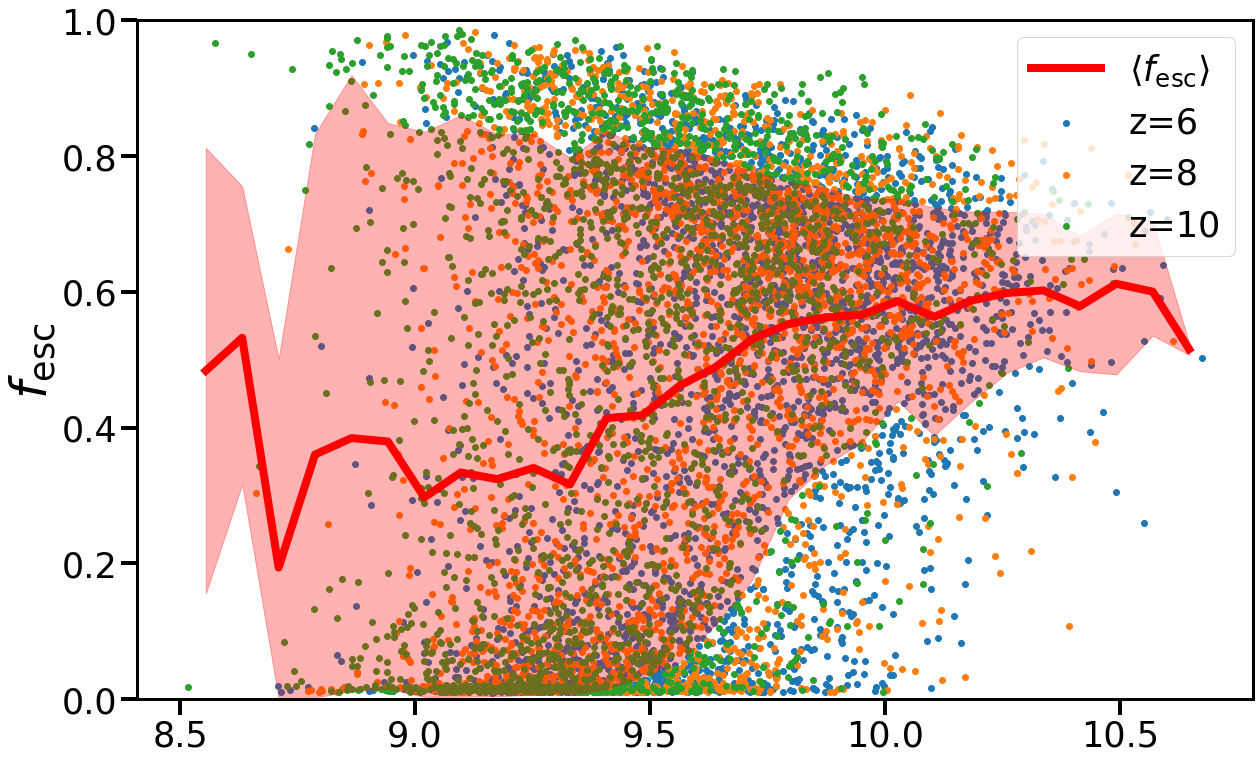

In [13]:
plot_scatter(new_results, halo_prop='HaloMass', bins=30, mode='mean', threshold=1e-2, 
                 include_frac=False, save=False, lin=True, galaxy=False, include_galaxy=False, include_var=False)

In [88]:
compare_fesc =build_compare_dic()

In [94]:
len(new_results)

8440

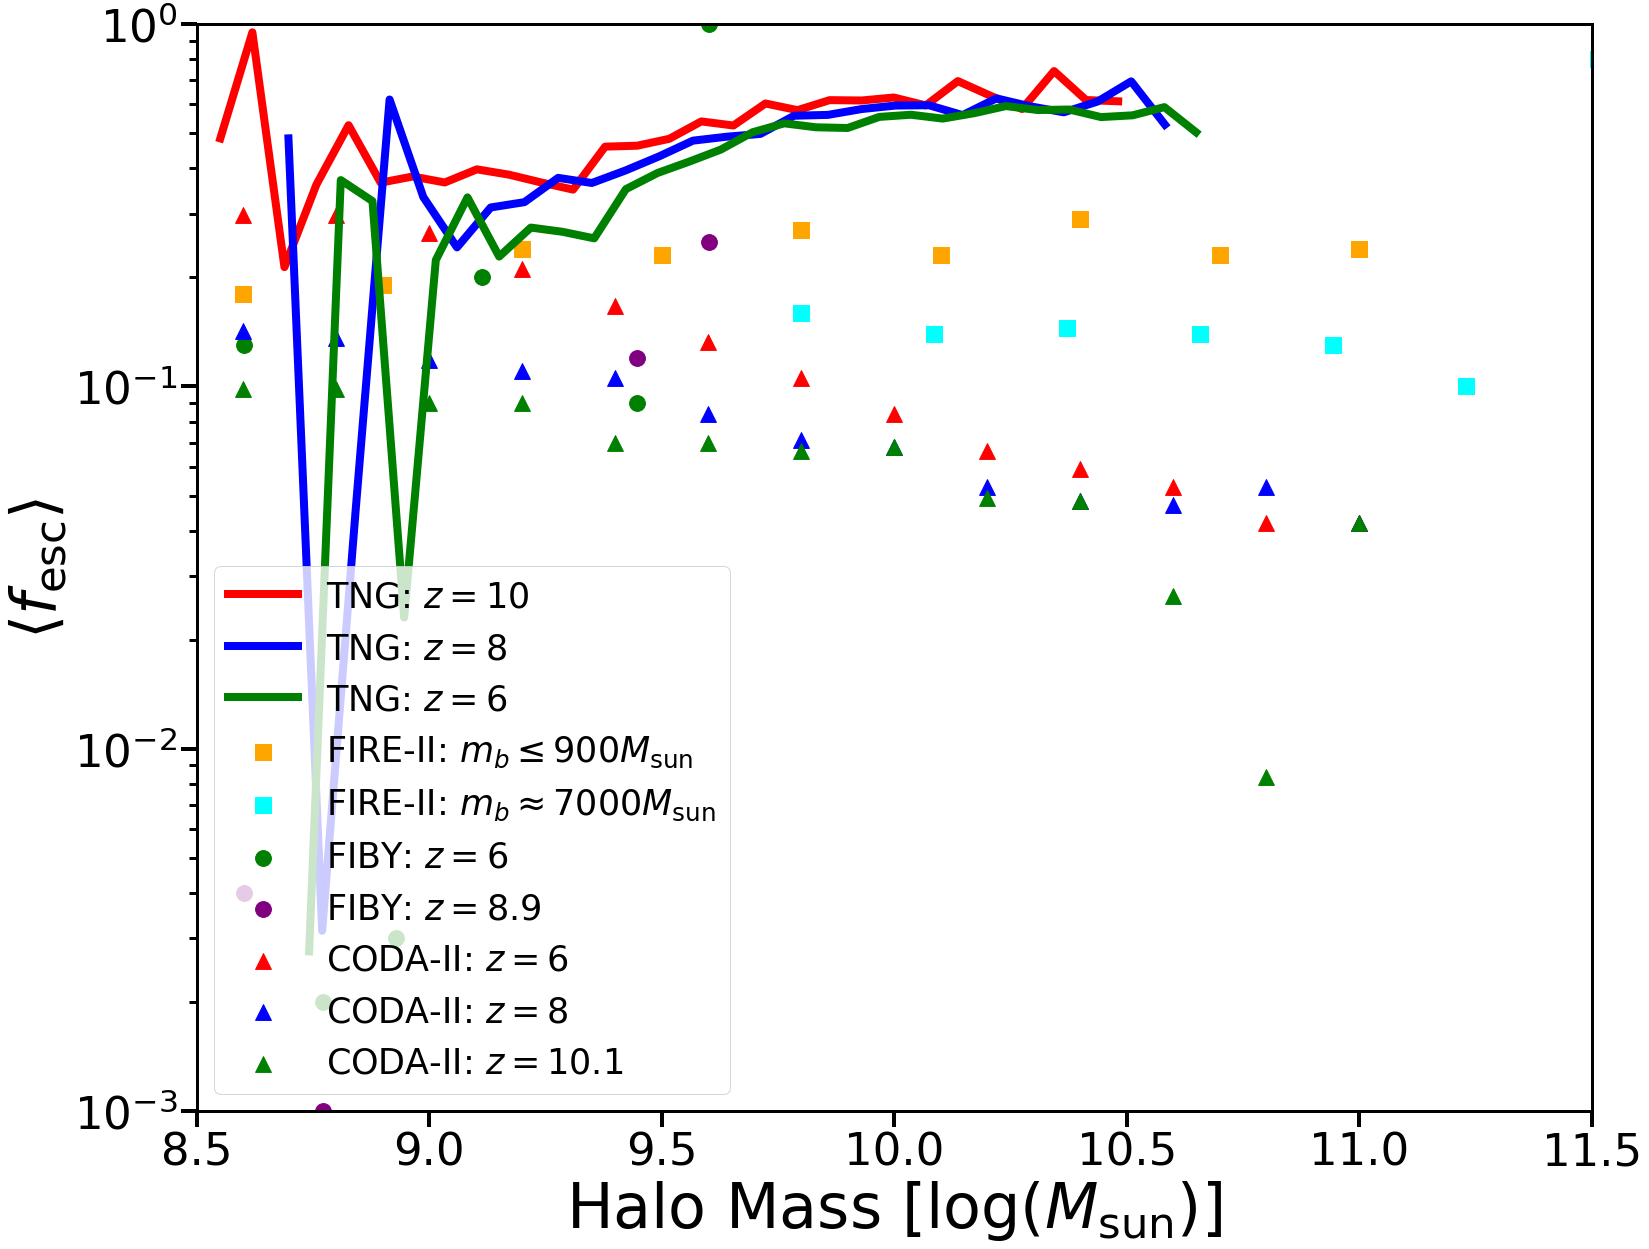

In [91]:
plot_lit_comparison(new_results, compare_fesc, include_subgrid=True, halo_prop='HaloMass', bins=30, mode='mean', save=True, lin=False)

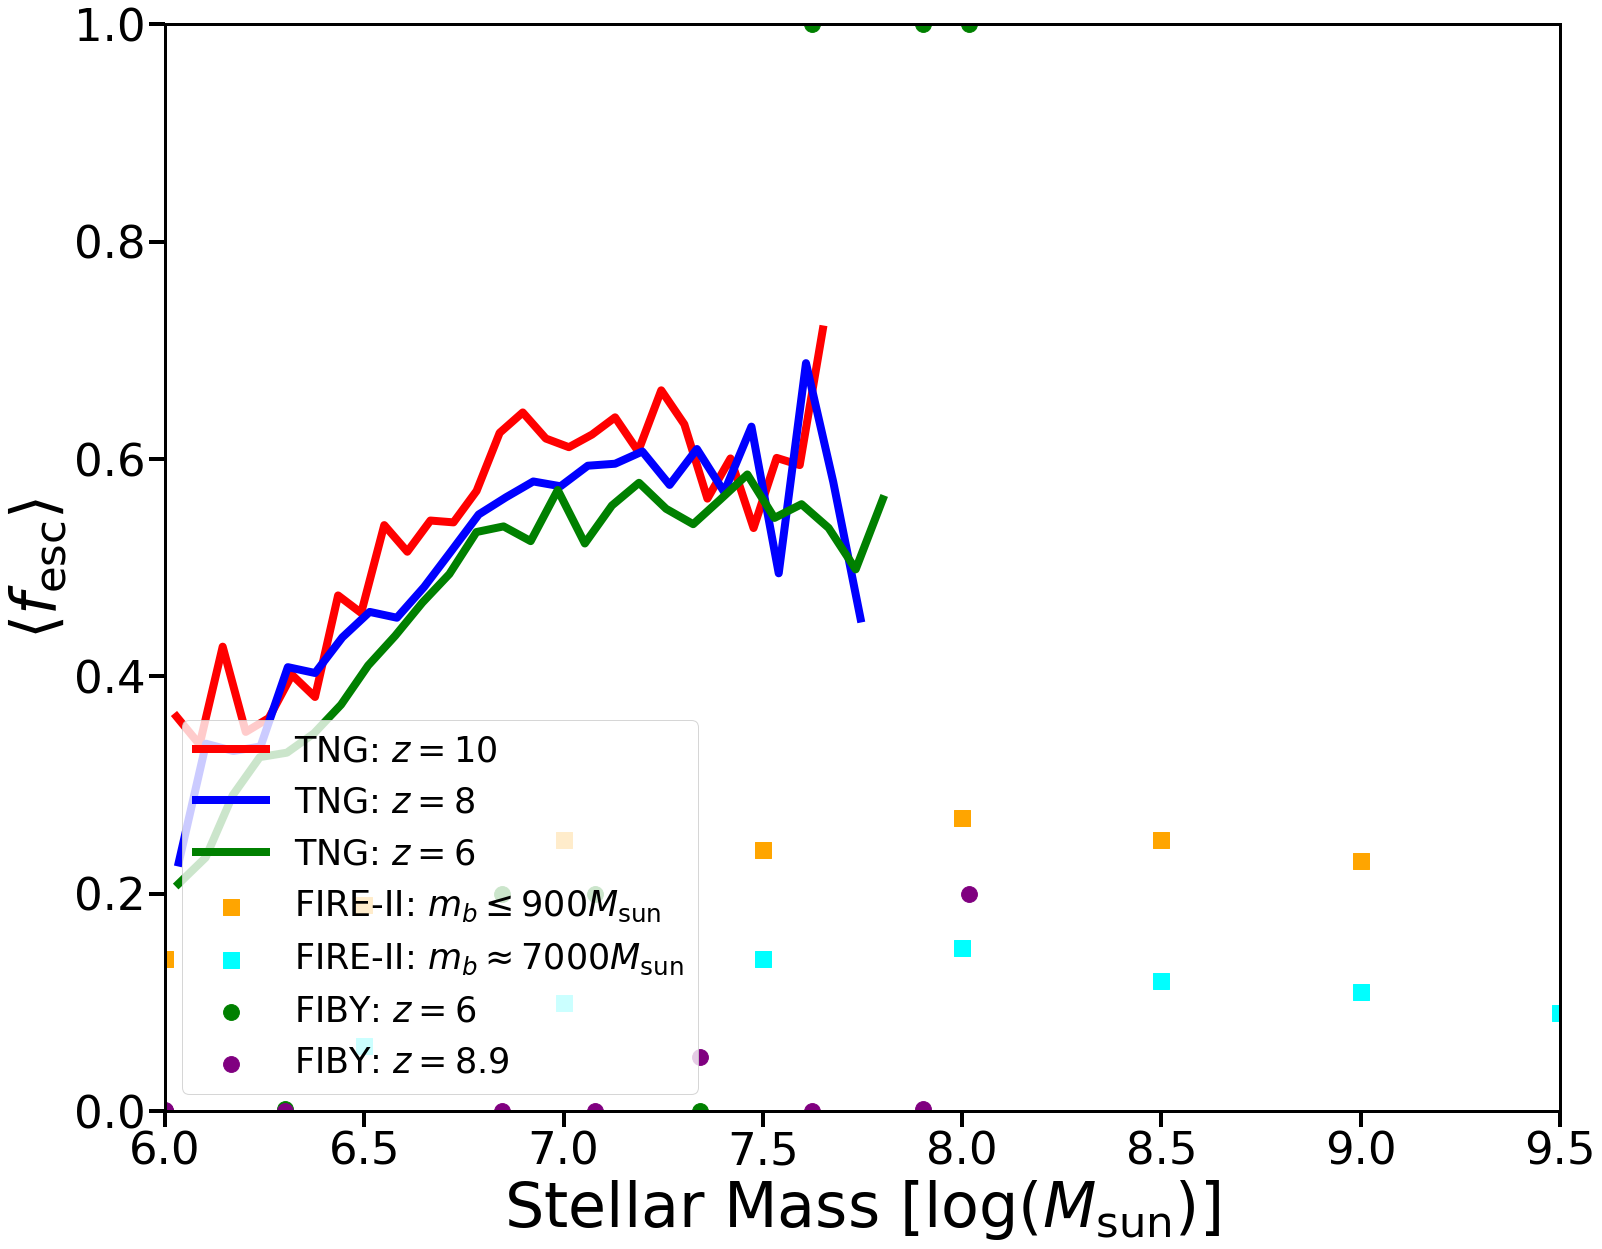

In [93]:
plot_lit_comparison(new_results, compare_fesc, include_subgrid=True, halo_prop='StarMass', bins=30, mode='mean', save=False, lin=True)